<h1> Regional malaria data with monthly weather information </h1>

In [1]:
from __future__ import division
import numpy as np
import json
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime
import csv
from scipy import interpolate
import psycopg2

from ethiopian_date import ethiopian_date
from scipy.signal import savgol_filter

Populating the interactive namespace from numpy and matplotlib


<h1> constants </h1>

In [2]:
START_DATE = '2014-07-01'

<h1> Functions </h1>

In [3]:
def set_to_first_of_month(Date):
    return datetime.date(Date.year, Date.month, 1)

def make_edate(date):
    '''If 13th month we move forward 6 days to avoid error. The 13th month is lumped in with the 1st month'''
    try:
        return ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date)
    except ValueError:
        return ethiopian_date.EthiopianDateConverter.date_to_ethiopian(date + pd.offsets.relativedelta(days=6))
    
def interpolate_between_dates(interp_date, region, yearly_pop):
    ''' Linear interpolation between dates 
        Input a single date and region 
        The yearly_pop data frame needs to have E_Date as the index'''
    #interp_dates = pd.DatetimeIndex(interp_dates)
    x_data = yearly_pop.loc[region].val.index
    y_data = yearly_pop.loc[region].val.values
    
    epoch = x_data[0]
    x_data = (x_data - epoch).total_seconds()
    interp_date = (interp_date - epoch).total_seconds()

    # Do a linear interpolation if outside of the range
    interp_fun = interpolate.interp1d(x_data, y_data, fill_value = "extrapolate")
    return int(interp_fun(interp_date))


<h1> Connect to psql DB and return the monthly weather dataframe </h1>

In [4]:
conn = psycopg2.connect("host=localhost port=5432 dbname=et_weather user=attiladobi")
cur = conn.cursor()

sql_query = 'SELECT * FROM monthly;'
monthly_weather = pd.read_sql_query(sql_query, conn)

monthly_weather['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) \
                                for date in monthly_weather['e_date']]
conn.close()
monthly_weather.rename(columns={'geokey': 'GeoKey'}, inplace=True)
# convert to datetime64
monthly_weather['e_date'] = monthly_weather['e_date'].astype(datetime64)
monthly_weather['RegionKey'] = monthly_weather['GeoKey'].apply(lambda x: '%s______' % x.split('__')[0])

# Group by regions and compute averages
monthly_weather= monthly_weather.groupby(['RegionKey', 'e_date']).mean().reset_index()

monthly_weather.head()

RegionKey     e_date  precipitation  max_precipitation  \
0  addis ababa______ 2005-04-01       2.065414           0.786827   
1  addis ababa______ 2005-05-01       6.054673           0.823472   
2  addis ababa______ 2005-06-01       5.302964           0.754839   
3  addis ababa______ 2005-07-01      29.403148           9.581333   
4  addis ababa______ 2005-08-01      33.965273          19.818000   

   days_precipitation  wind_avg   temp_max  temp_min   temp_avg   humid_max  \
0                 4.8  2.934585  33.877000     8.758  24.333313   58.530999   
1                13.0  3.555636  36.014000    11.036  21.412850   80.034000   
2                11.8  4.580507  36.999001     9.563  23.067533   78.787999   
3                23.4  4.200907  36.793000    12.334  24.999650   94.648001   
4                18.3  4.181346  35.554999    14.959  24.348550  100.000000   

   humid_min  humid_avg        solar  
0      0.000  20.893563  5412.670520  
1      0.000  38.603683  5413.317352  
2      0.000  33.561217  6310.729473  
3      5.655  42.919983  4711.175104  
4      6.588  47.842533  4753.156989

<h1> load in indicator ID mapping </h1>

In [51]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators

useful_groups = config.et.indicators.HMIS_GROUPS + \
    config.et.composite_indicators.HMIS_GROUPS + \
    config.et.indicators.NNPMT_GROUPS + \
    config.et.indicators.HSTP_GROUPS + \
    [config.et.indicators.CALCULATED_INDICATOR_GROUP] + config.et.indicators.SPA_GROUPS
IDlookup = {val['id']:val for cluster in useful_groups for val in cluster['indicators']}

<h1> New and improved way to do it </h1>

In [112]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators
IDlookup = {val['id']:val for cluster in config.et.indicators.GROUP_DEFINITIONS for val in cluster['indicators']}

<h1> Load in region level malaria data </h1>

In [113]:
# with open('/Users/attiladobi/Downloads/Malaria_region_20170203.json', 'rb') as f:
with open('/Users/attiladobi/Downloads/2017-03-07_malaria_region.json', 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF2 = pd.read_json(data_json_str)

In [114]:
df_list = []
for region in DF2['byGeo'][0].keys():
    region_name = region.split('_')[0]
    meta_data = pd.DataFrame(DF2['byGeo'][0][region]['data']['month'])
    formatted_data = pd.DataFrame(meta_data[1:].stack()).reset_index(level=0)
    formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    formatted_data.columns = ['Indicator_id', 'val']
    formatted_data.index.name = 'Real_Date'
    formatted_data['Region'] = region_name
    # Drop data that doesn't have indicator information. They start with Real_Date
    formatted_data = formatted_data[formatted_data['Indicator_id'] != 'Real_Date']
    df_list.append(formatted_data)
DF_ind=pd.concat(df_list)
DF_ind['Indicator'] = [IDlookup[val]['text'] for val in DF_ind['Indicator_id']]
# enfore data type for aggregations
DF_ind['val'] = DF_ind['val'].astype('float')

# Data starts after 2014-07-01
DF_ind= DF_ind[DF_ind.index > pd.to_datetime(START_DATE)]

#Note: region_name, zone_name, woreda_name are all lower case

In [9]:
DF_ind.head()

Indicator_id      val Region  \
Real_Date                                            
2014-07-08  composite_indicator_47   5786.0   afar   
2014-08-07  composite_indicator_47   5760.0   afar   
2014-09-06  composite_indicator_47   7952.0   afar   
2014-10-11  composite_indicator_47   9759.0   afar   
2014-11-10  composite_indicator_47  10696.0   afar   

                                               Indicator  
Real_Date                                                 
2014-07-08  Number of slides or RDT positive for malaria  
2014-08-07  Number of slides or RDT positive for malaria  
2014-09-06  Number of slides or RDT positive for malaria  
2014-10-11  Number of slides or RDT positive for malaria  
2014-11-10  Number of slides or RDT positive for malaria

<h1> Label gender, age and inferction catagories </h1>

In [10]:
# Indicators used for fitting
ind_total = 'Number of slides or RDT positive for malaria'
ind_f_5 = 'Number of slides or RDT positive for malaria < 5 years: Females'
ind_m_5 = 'Number of slides or RDT positive for malaria < 5 years: Males'
ind_f_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Females'
ind_m_5_14 = 'Number of slides or RDT positive for malaria 5-14 years: Males'
ind_f_15_up = 'Number of slides or RDT positive for malaria >=15 years: Females'
ind_m_15_up = 'Number of slides or RDT positive for malaria >=15 years: Males'

ind_names = [ind_total, ind_f_5, ind_m_5, ind_f_5_14, ind_m_5_14, ind_f_15_up, ind_m_15_up]
ind_age_cat = [4, 1, 1, 2, 2, 3, 3]
ind_gender_cat = [3, 2, 1, 2, 1, 2, 1]
name_to_gen_age_map = {ind_name: (gender, age) for ind_name, gender, age in zip(ind_names, ind_gender_cat, ind_age_cat)}

def lookup_gen_age(ind_name):
    keys = ('gender', 'age')
    if ind_name in name_to_gen_age_map:
        return dict(zip(keys, name_to_gen_age_map[ind_name]))
    else:
        return dict(zip(keys, (0, 0)))
    
def is_male(ind_name):
    return 1 if (lookup_gen_age(ind_name)['gender'] == 1) else 0
def is_child(ind_name):
    return 1 if (lookup_gen_age(ind_name)['age'] == 1) else 0
def is_teen(ind_name):
    return 1 if (lookup_gen_age(ind_name)['age'] == 2) else 0

def is_male_child(is_male, is_child, is_teen):
    return 1 if (is_male and is_child) else 0
def is_female_child(is_male, is_child, is_teen):
    return 1 if (not is_male and is_child) else 0
def is_male_teen(is_male, is_child, is_teen):
    return 1 if (is_male and is_teen) else 0
def is_female_teen(is_male, is_child, is_teen):
    return 1 if (not is_male and is_teen) else 0
def is_male_adult(is_male, is_child, is_teen):
    return 1 if (is_male and not is_teen and not is_child) else 0

# Check if the inficetion rate in the region is high (on average over 1000 per month)
mean_monthly_total = DF_ind[DF_ind['Indicator']==ind_total].groupby(['Region']).val.mean()
is_high_list = mean_monthly_total[mean_monthly_total > 1000].index

DF_ind['is_male'] = [is_male(ind_name) for ind_name in DF_ind['Indicator']]
DF_ind['is_child'] = [is_child(ind_name) for ind_name in DF_ind['Indicator']]
DF_ind['is_teen'] = [is_teen(ind_name) for ind_name in DF_ind['Indicator']]


DF_ind['is_male_child'] = (DF_ind['is_male'].astype(bool)  & DF_ind['is_child'].astype(bool)).astype(int)
DF_ind['is_female_child'] = (~DF_ind['is_male'].astype(bool)  & DF_ind['is_child'].astype(bool)).astype(int)
DF_ind['is_male_teen'] = (DF_ind['is_male'].astype(bool)  & DF_ind['is_teen'].astype(bool)).astype(int)
DF_ind['is_female_teen'] = (~DF_ind['is_male'].astype(bool)  & DF_ind['is_teen'].astype(bool)).astype(int)
DF_ind['is_male_adult'] = (DF_ind['is_male'].astype(bool)  & ~DF_ind['is_teen'].astype(bool) \
                         & ~DF_ind['is_child'].astype(bool)).astype(int)

DF_ind['rate_is_high'] = [1 if region in is_high_list else 0 for region in DF_ind['Region']]


<h1> Add Ethiopian dates </h1>

In [11]:
e_dates = []
for date in DF_ind.index:
    ''' Except error if we land in the 13th month. Shift the date by 6 days'''
    try:
        e_dates.append(make_edate(date))
    except ValueError:
        e_dates.append(make_edate(date))
DF_ind['E_Date'] = [set_to_first_of_month(date) for date in e_dates] # another patch for the 13th month
DF_ind['E_Date'] = DF_ind['E_Date'].astype(datetime64)
DF_ind['E_year'] = [val.year for val in DF_ind['E_Date']]
DF_ind['E_month'] = [val.month for val in DF_ind['E_Date']]
DF_ind['month'] = DF_ind.index.month
DF_ind['year'] = DF_ind.index.year
DF_ind.reset_index(inplace=True)
DF_ind.head()

Real_Date            Indicator_id      val Region  \
0 2014-07-08  composite_indicator_47   5786.0   afar   
1 2014-08-07  composite_indicator_47   5760.0   afar   
2 2014-09-06  composite_indicator_47   7952.0   afar   
3 2014-10-11  composite_indicator_47   9759.0   afar   
4 2014-11-10  composite_indicator_47  10696.0   afar   

                                      Indicator  is_male  is_child  is_teen  \
0  Number of slides or RDT positive for malaria        0         0        0   
1  Number of slides or RDT positive for malaria        0         0        0   
2  Number of slides or RDT positive for malaria        0         0        0   
3  Number of slides or RDT positive for malaria        0         0        0   
4  Number of slides or RDT positive for malaria        0         0        0   

   is_male_child  is_female_child  is_male_teen  is_female_teen  \
0              0                0             0               0   
1              0                0             0               0   
2              0                0             0               0   
3              0                0             0               0   
4              0                0             0               0   

   is_male_adult  rate_is_high     E_Date  E_year  E_month  month  year  
0              0             1 2006-11-01    2006       11      7  2014  
1              0             1 2006-12-01    2006       12      8  2014  
2              0             1 2007-01-01    2007        1      9  2014  
3              0             1 2007-02-01    2007        2     10  2014  
4              0             1 2007-03-01    2007        3     11  2014

<h1> Group population data by Ethiopian year </h1>

In [12]:
population_data = DF_ind[DF_ind['Indicator']=='Population'].reset_index()
population_data['val'] = population_data.val.astype(float)
yearly_pop = population_data.groupby(['Region', population_data['E_Date'].map(lambda x: x.year)]).val.mean()
yearly_pop = yearly_pop.reset_index()
yearly_pop['E_Date'] = pd.to_datetime(yearly_pop['E_Date'], format='%Y')
yearly_pop.set_index(['Region', 'E_Date'], inplace=True)
#yearly_pop

<h1> Add population data for every E_Date in the dateframe </h1>

In [13]:
DF_ind['pop'] = [interpolate_between_dates(edate, region, yearly_pop) for edate, region in DF_ind[['E_Date', 'Region']].values]

<h1> Plot the interpolation of population for all regions </h1>

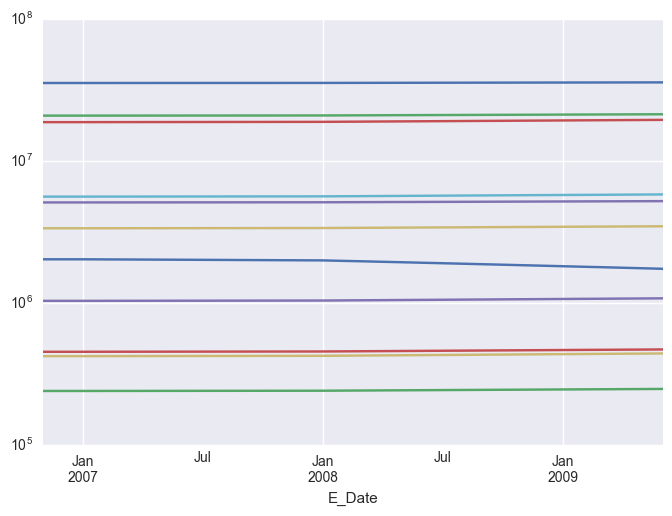

In [14]:
regions = DF_ind['Region'].unique()
for region in regions:
    DF_ind.groupby(['Region', 'E_Date']).pop.mean().loc[region].plot()
yscale('log')

<h1> Add GeoKey to the dataframe </h1>

In [15]:
GEO_COLS = ['Region', 'Zone', 'Woreda']
name_cols = [column for column in DF_ind.columns if column in GEO_COLS]
end_dash = '__' * (4 - len(name_cols))
DF_ind['GeoKey'] = DF_ind[name_cols].apply(lambda x: '%s%s' % ('__'.join(x).lower(), end_dash), axis=1)
    
DF_ind['RegionKey'] = DF_ind['Region'].apply(lambda x: '%s______' % x.split('__')[0])

<h1> Load in the region_info.csv file for area and elevation </h1>

In [16]:
region_info = pd.read_csv('/Users/attiladobi/PyNotebooks/zenysis/mapped_info/region_info.csv')

<h1> Add region info to the DF by joining </h1>

In [17]:
DF_ind = DF_ind.merge(region_info, on='GeoKey', how='inner')
DF_ind['density'] = DF_ind['pop'] / DF_ind['Area_km2']
DF_ind['infection_rate'] = DF_ind['val'] / DF_ind['pop'] #only applies to one indicator: indicator = 'Number of slides or RDT positive for malaria'


<h1> Add total number of RTDs </h1>

In [18]:
rdt_total = 'Total number of slides or RDT performed for malaria diagnosis'
malaria_tests = DF_ind.loc[DF_ind['Indicator']==rdt_total][['GeoKey', 'E_Date', 'val']]
malaria_tests.rename(columns={'val': 'RDT_total'}, inplace=True)
DF_ind = DF_ind.merge(malaria_tests, on=['E_Date', 'GeoKey'], how='left')


<h1> Add insecticide net fraction data </h1> 

In [19]:
indicator = 'Number of slides or RDT positive for malaria'
DF_mean = DF_ind.loc[DF_ind['Indicator']==indicator].groupby('Region').mean()

ind_nets = 'Proportion of targeted HH covered with LLIN in the last 12 months'
DF_mean_nets = DF_ind.loc[DF_ind['Indicator']==ind_nets].groupby('Region').mean()
#add back Addis info:
DF_mean_nets.loc['addis ababa'] =  DF_mean_nets.loc['oromiya']
DF_ind['net_frac'] = [DF_mean_nets.val[region] for region in DF_ind['Region']]


<h1> Add average monthly weather data. Along with shifted values </h1>

In [20]:
for i in range(0,7):
    # if first one, skip the suffix (left, right)
    suffixes = ('', '') if i==0 else ('', '_shift_%s' % i)
    # Keep with convention of value reporting. First of month is for averages of the previous month
    monthly_weather['E_Date'] = [date + pd.offsets.relativedelta(months=i+1) for date in monthly_weather['e_date']]
    # Merge onto original dataframe, ignore e_date column that represents monthly grouping
    DF_ind = DF_ind.merge(monthly_weather.drop('e_date', axis=1), on=['E_Date', 'RegionKey'], how='left', suffixes=suffixes)
DF_ind.head()

Real_Date            Indicator_id      val Region  \
0 2014-07-08  composite_indicator_47   5786.0   afar   
1 2014-08-07  composite_indicator_47   5760.0   afar   
2 2014-09-06  composite_indicator_47   7952.0   afar   
3 2014-10-11  composite_indicator_47   9759.0   afar   
4 2014-11-10  composite_indicator_47  10696.0   afar   

                                      Indicator  is_male  is_child  is_teen  \
0  Number of slides or RDT positive for malaria        0         0        0   
1  Number of slides or RDT positive for malaria        0         0        0   
2  Number of slides or RDT positive for malaria        0         0        0   
3  Number of slides or RDT positive for malaria        0         0        0   
4  Number of slides or RDT positive for malaria        0         0        0   

   is_male_child  is_female_child      ...        max_precipitation_shift_6  \
0              0                0      ...                         1.339688   
1              0                0      ...                         1.690469   
2              0                0      ...                         4.297604   
3              0                0      ...                        31.871721   
4              0                0      ...                        17.432187   

   days_precipitation_shift_6  wind_avg_shift_6  temp_max_shift_6  \
0                     1.06250          4.607471         31.729375   
1                     1.03125          4.684676         35.016875   
2                     2.81250          4.738805         32.710000   
3                     8.06250          3.853319         35.167188   
4                     5.65625          2.503037         35.535313   

  temp_min_shift_6  temp_avg_shift_6  humid_max_shift_6  humid_min_shift_6  \
0        17.376563         24.968401          73.876250           0.000000   
1        18.146875         25.579599          74.406250           0.238437   
2        19.617813         26.310323          83.578750           3.816875   
3        21.667500         28.155510          89.294063          13.656250   
4        20.495313         29.326813          80.504687           5.435938   

   humid_avg_shift_6  solar_shift_6  
0          30.050594    4101.411901  
1          24.762885    4116.578617  
2          43.337208    5208.527567  
3          46.343120    5095.890343  
4          43.156984    5040.610394  

[5 rows x 112 columns]

<h3> black magic to remove Nulls from wind_avg data in trigray and replace them with the following year's value </h3>

In [21]:
# Following format: df.loc[(df['column1'] == some_value) & (df['column2'] == some_other_value), ['column_to_change']] = new_value
monthly_weather.loc[(monthly_weather['wind_avg'].isnull()), ['wind_avg']] = \
[monthly_weather.loc[(monthly_weather['RegionKey']==region) & (monthly_weather['e_date'] == e_date + \
                    pd.offsets.relativedelta(months=12))]['wind_avg'].values[0] for region, e_date in \
    monthly_weather.loc[monthly_weather['wind_avg'].isnull()][['RegionKey', 'e_date']].values]

In [22]:
print 'OH OH, NULL Values' if monthly_weather.isnull().sum().sum()>0 else 'Weather DF all good'

Weather DF all good


<h1> One hot encode ET month </h1>

In [23]:
# Get one hot encoding of columns B
onehot_month = pd.get_dummies(DF_ind['E_month'])
onehot_month.rename(columns={num: 'is_emonth_%s' % num for num in onehot_month.columns}, inplace=True)
# Drop column B as it is now encoded
#DF_ind = DF_ind.drop('E_month', axis=1)
# Join the encoded df
DF_ind = DF_ind.join(onehot_month)

<h1> One hot encode the region </h1>

In [24]:
# Get one hot encoding of columns B
onehot_region = pd.get_dummies(DF_ind['Region'])
onehot_region.rename(columns={region: 'is_%s' % region for region in onehot_region.columns}, inplace=True)
DF_ind = DF_ind.join(onehot_region)

<h1> SG filter on malaria indicators</h1>

In [25]:
malaria_indicators = [name for name in DF_ind['Indicator'].unique() if ('Males' in name or 'Females' in name)]
indicator_cut = [name in malaria_indicators for name in DF_ind['Indicator']]
DF_ind_malaria = DF_ind[indicator_cut].copy()

In [26]:
dfs = []

for region in regions:
    for indicator in malaria_indicators:
        ind_data = DF_ind_malaria[(DF_ind_malaria['Region'] == region) & (DF_ind_malaria['Indicator'] == indicator)]
        index = ind_data.index
        sg_vals = savgol_filter(ind_data.val.values, 9, 2)
        dfs.append(pd.DataFrame(sg_vals, index=index, columns=['sg_val']))
        #figure()
        #plt.plot(savgol_filter(ind_data.val.values, 9, 2))
        #plt.plot(ind_data.val.values)
# retrevie elements from lists in a list
sg_df = pd.concat(dfs)
sg_df['sg_val'][sg_df['sg_val'] < 0] = 1
DF_ind_malaria['sg_val'] = sg_df['sg_val']

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


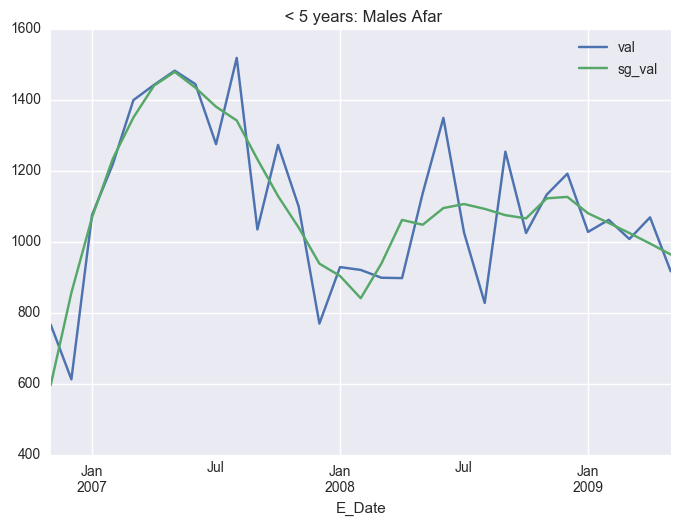

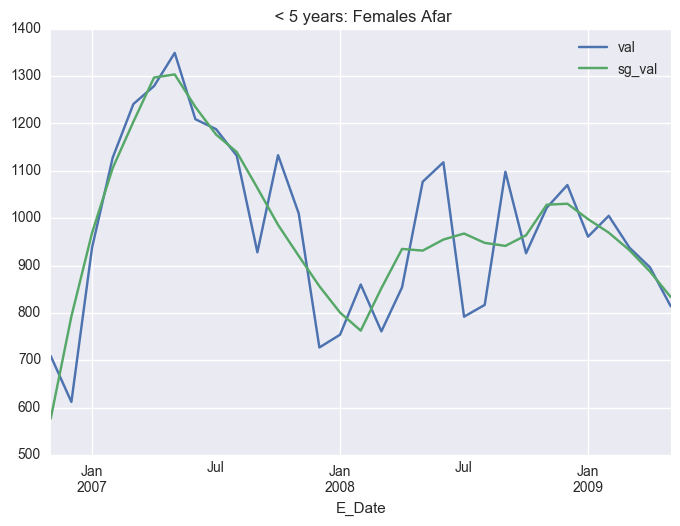

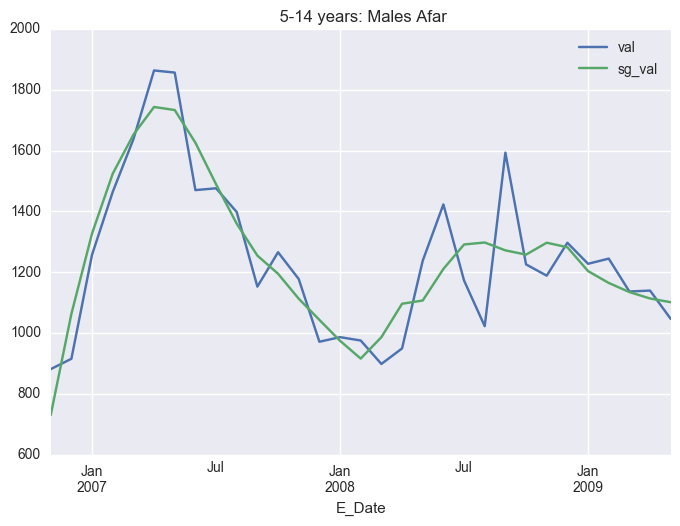

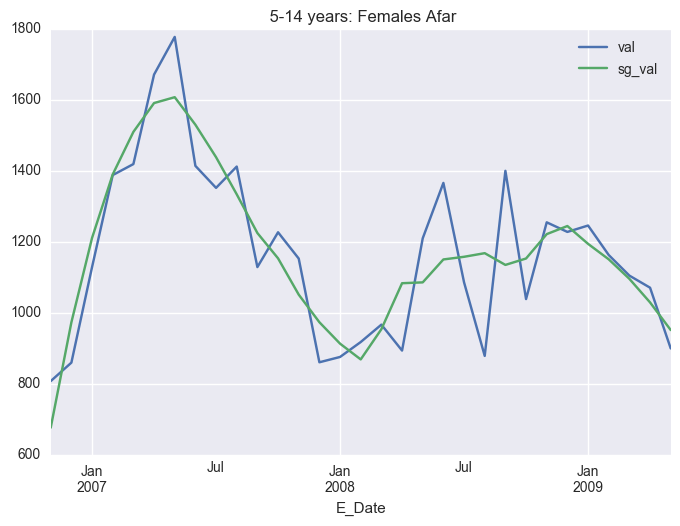

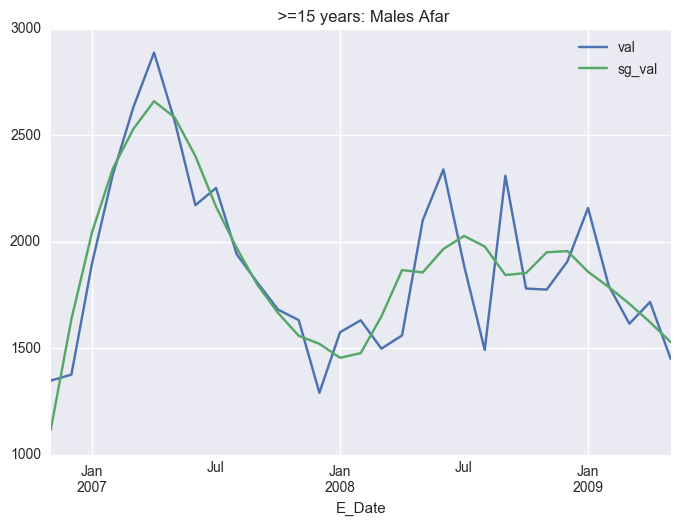

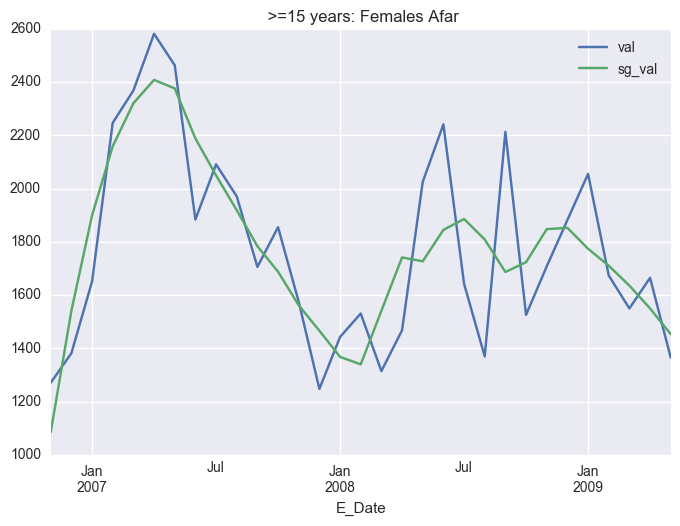

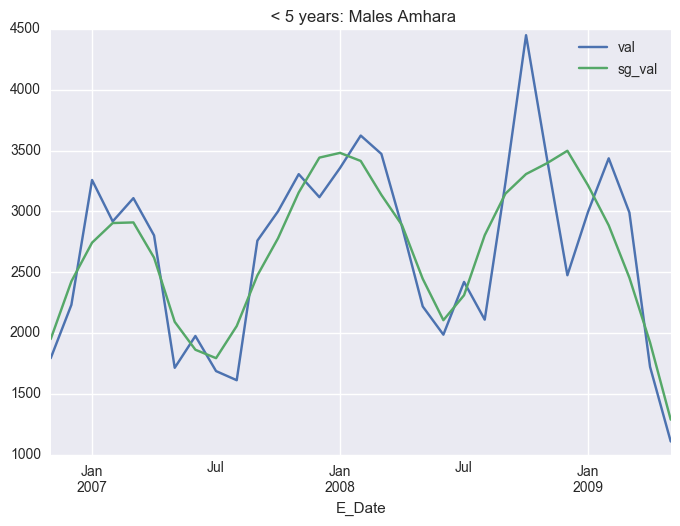

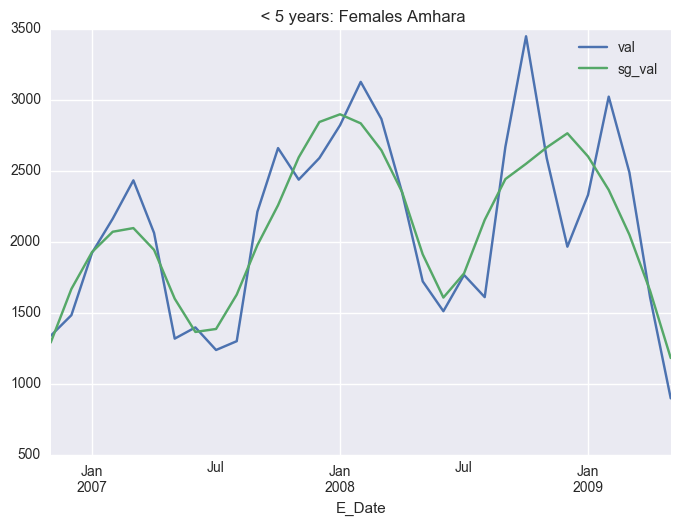

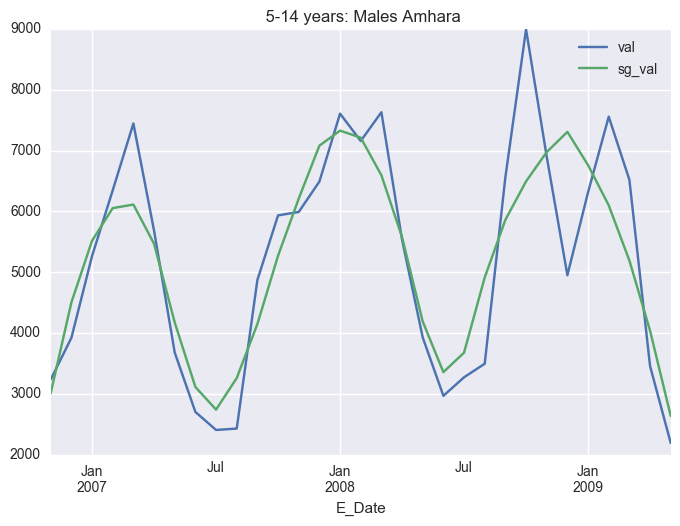

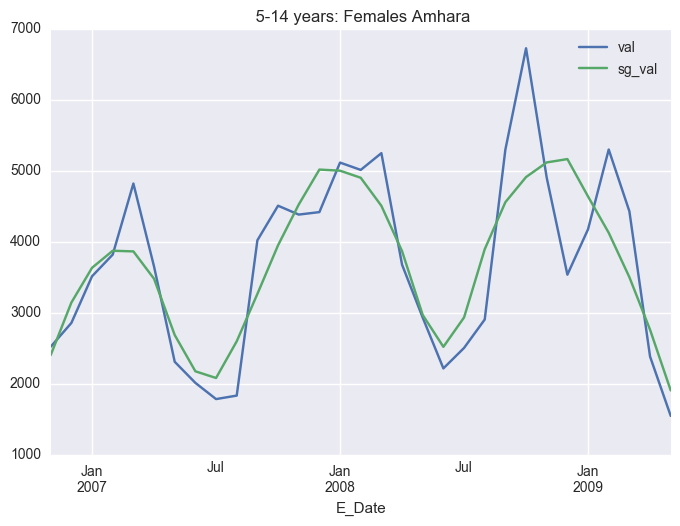

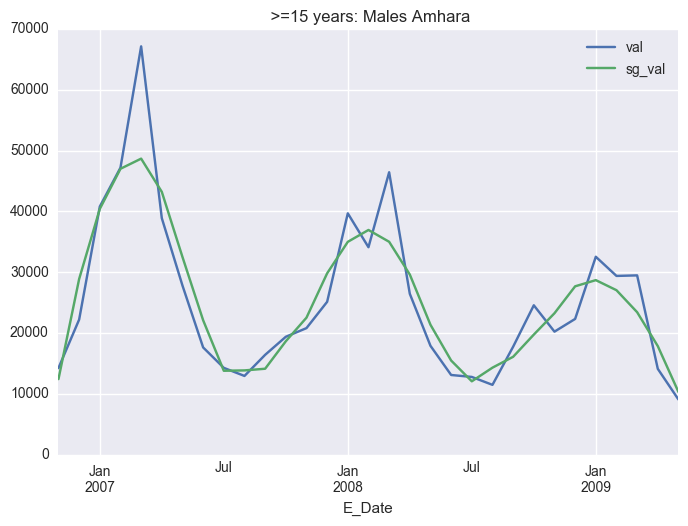

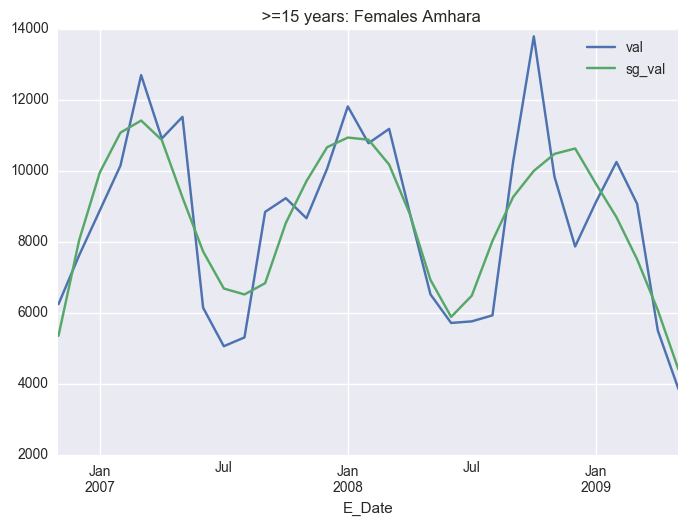

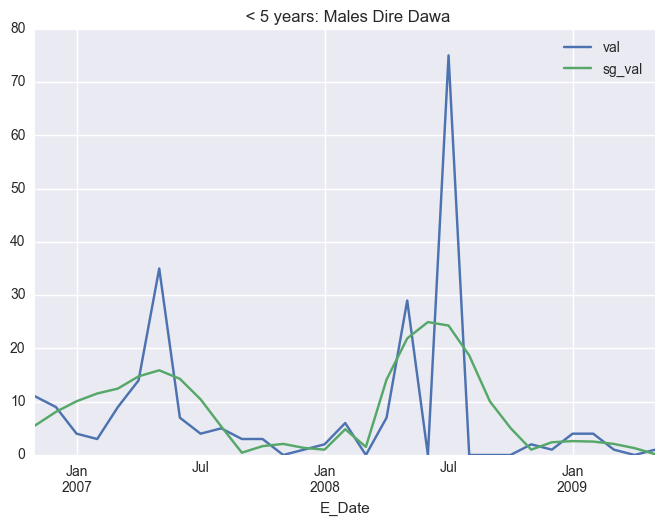

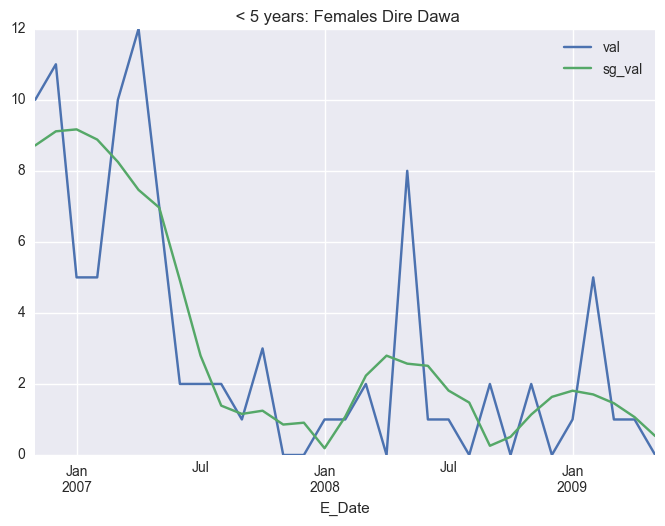

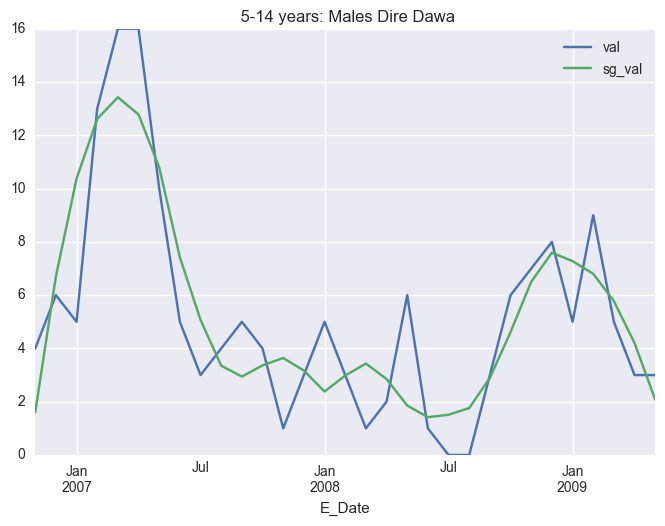

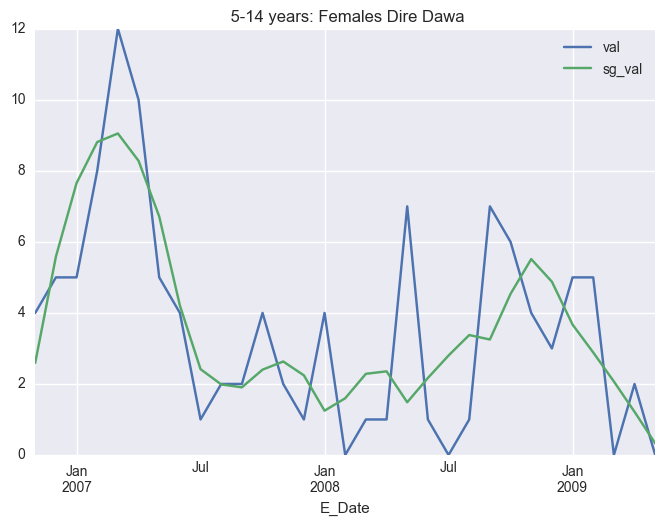

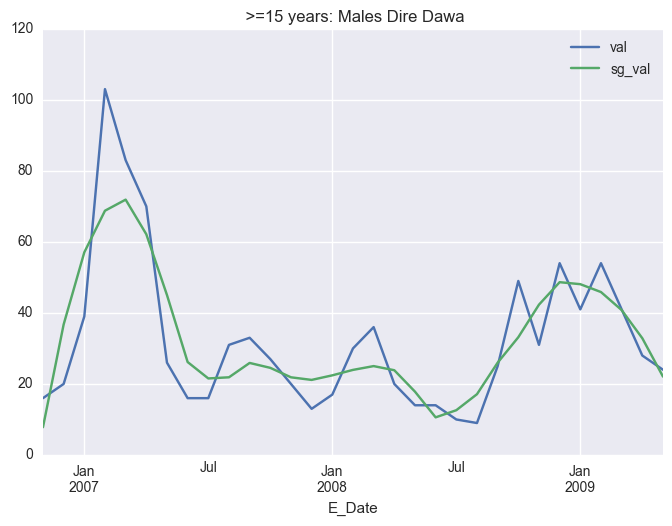

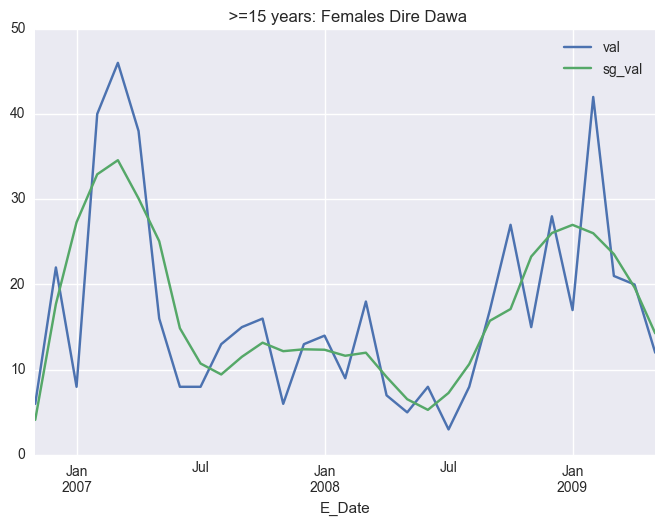

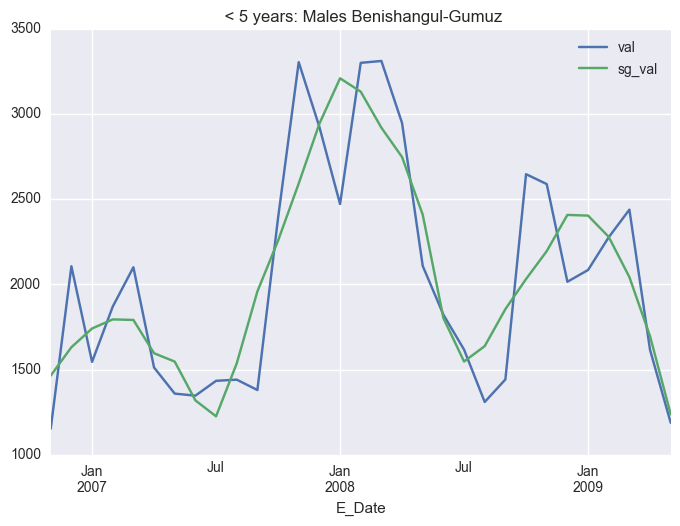

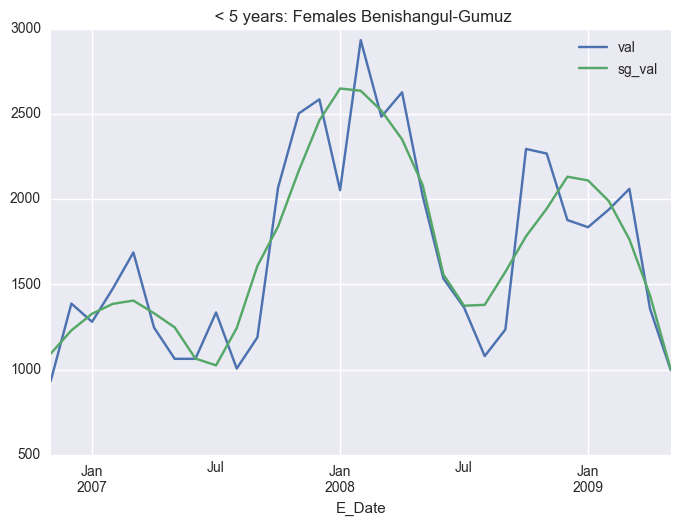

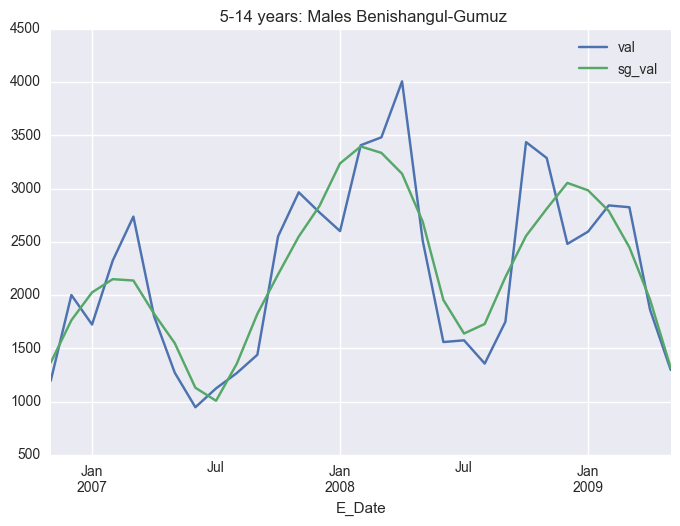

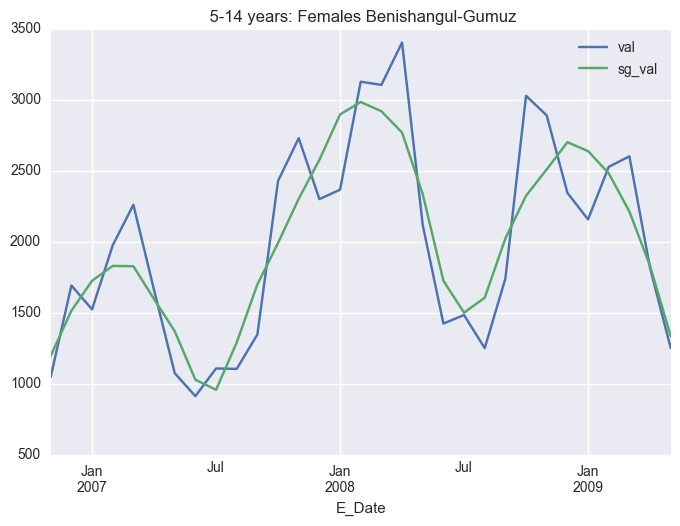

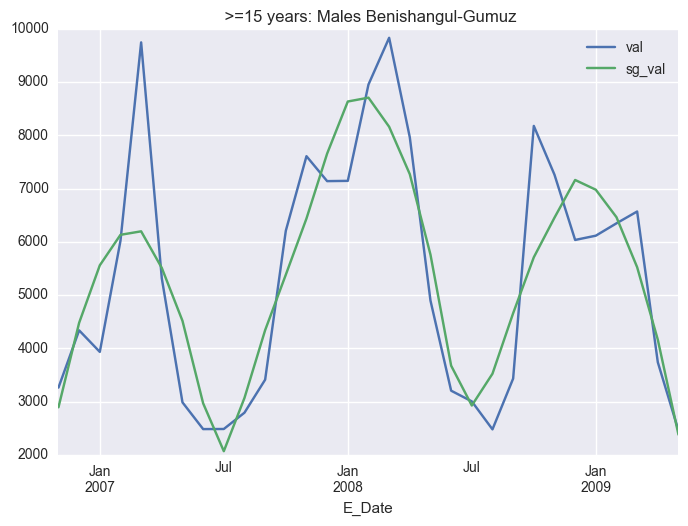

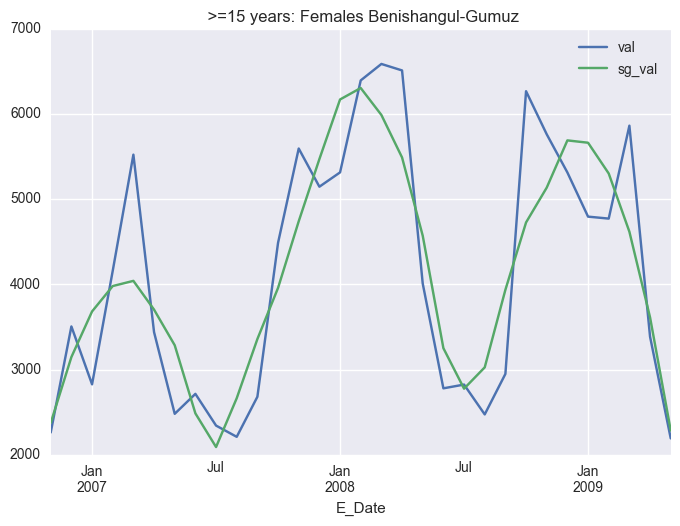

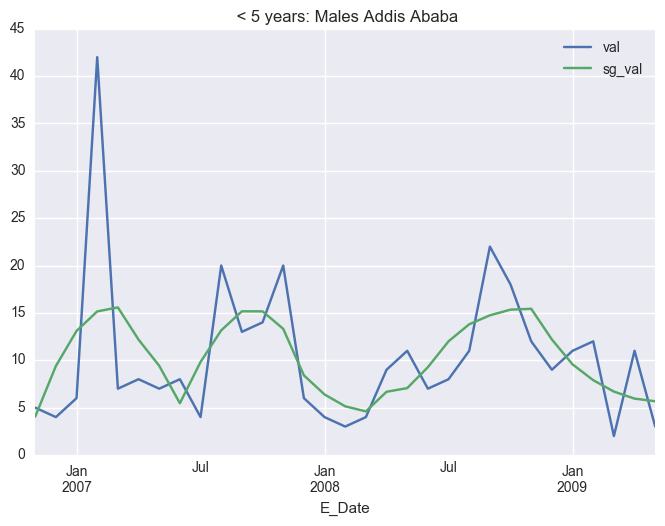

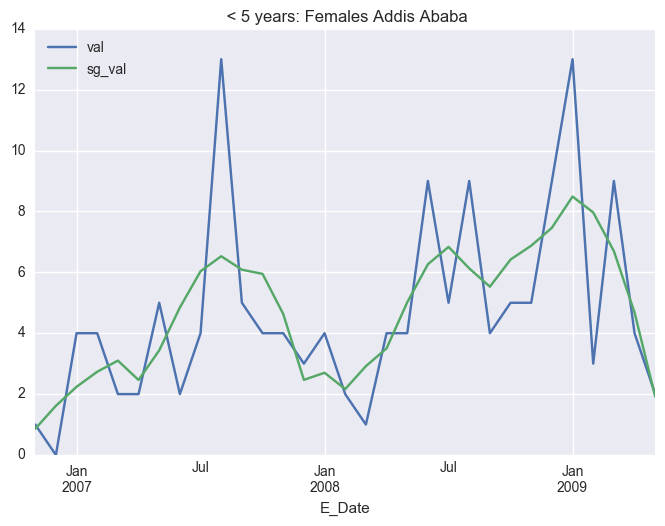

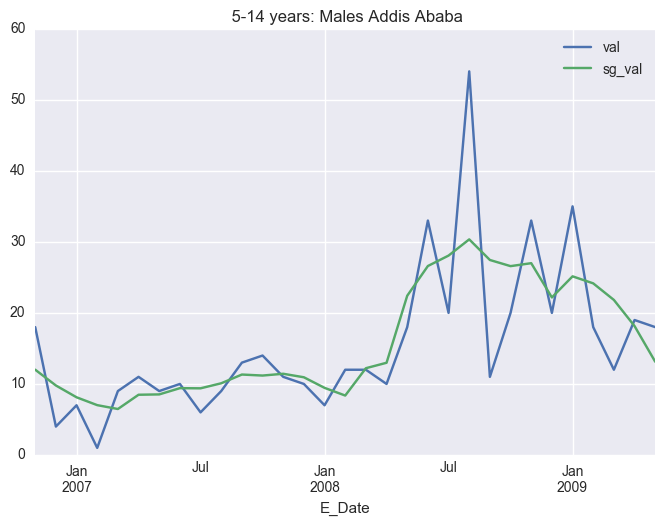

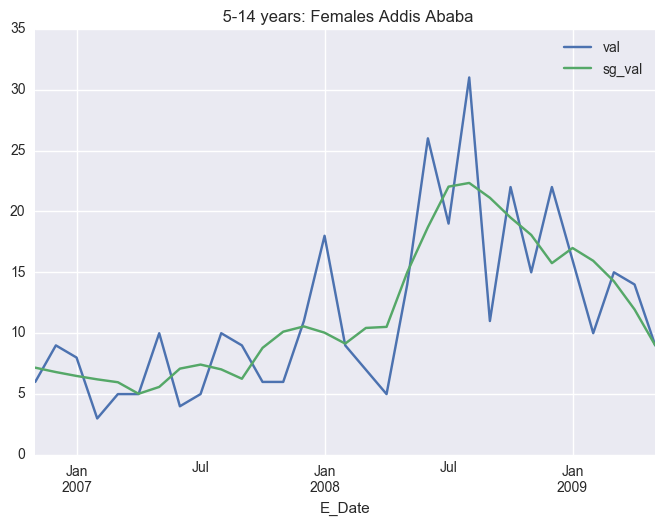

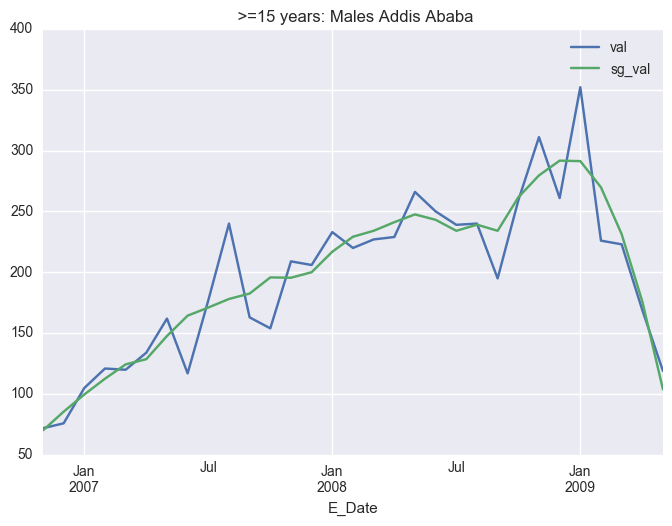

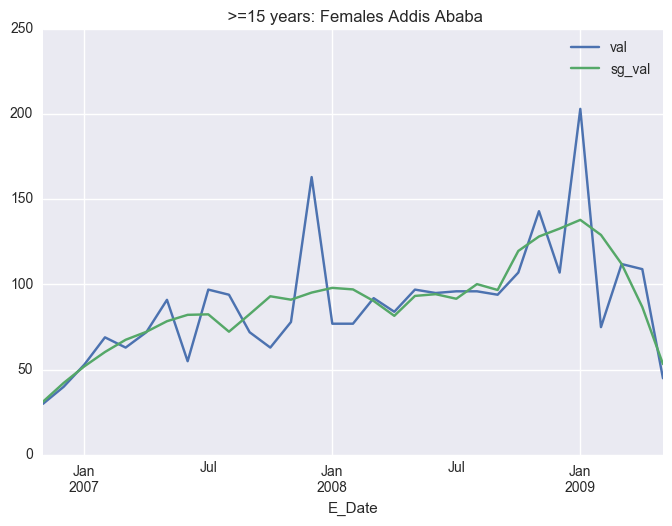

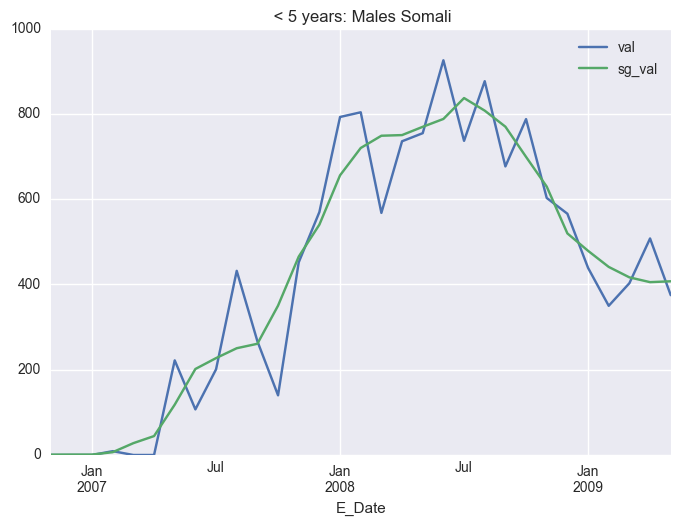

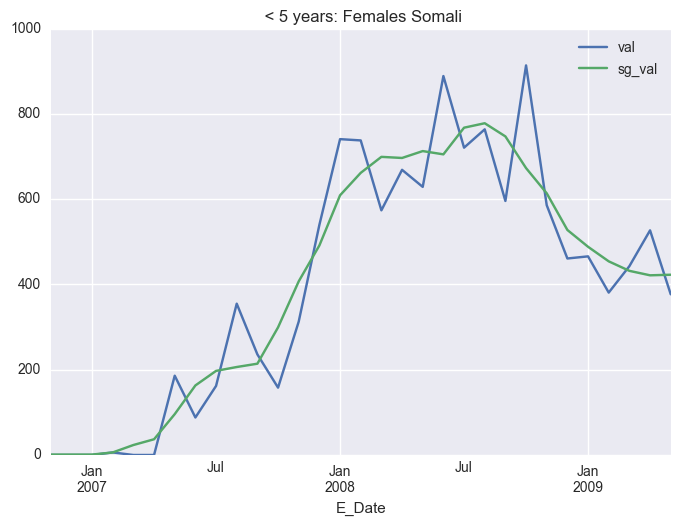

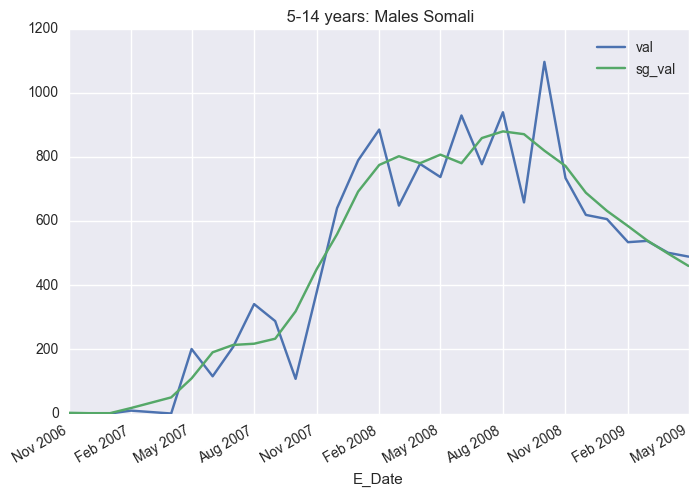

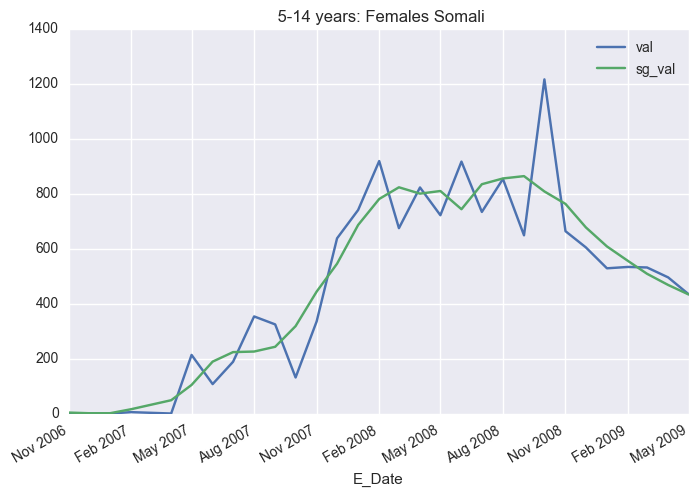

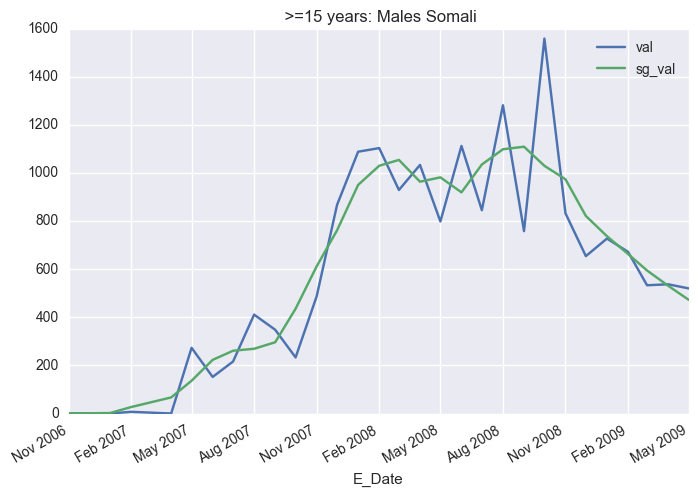

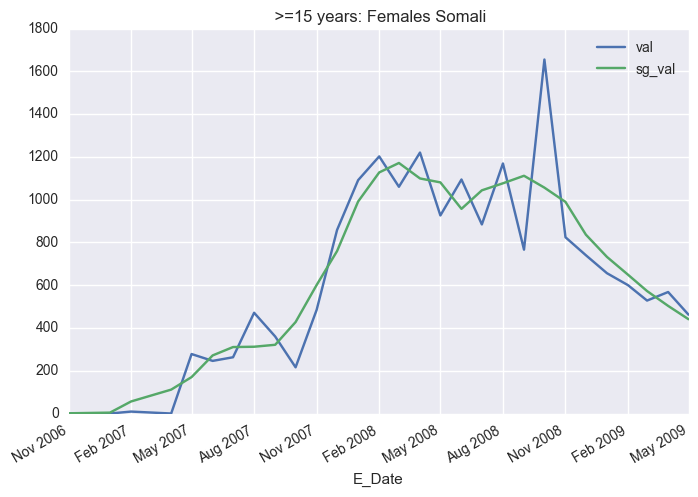

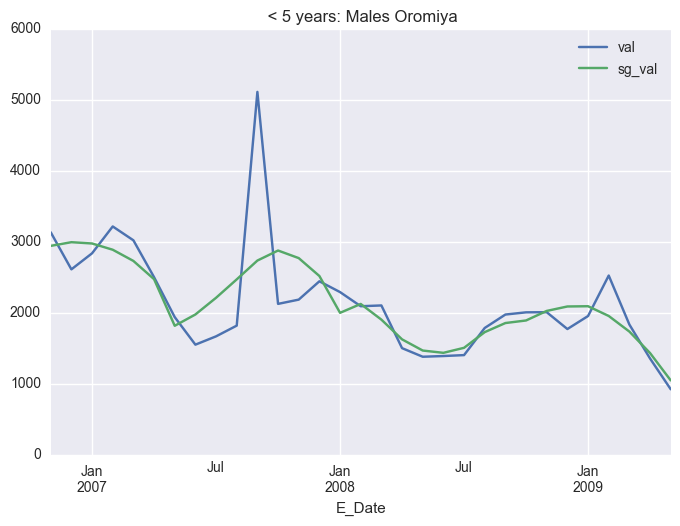

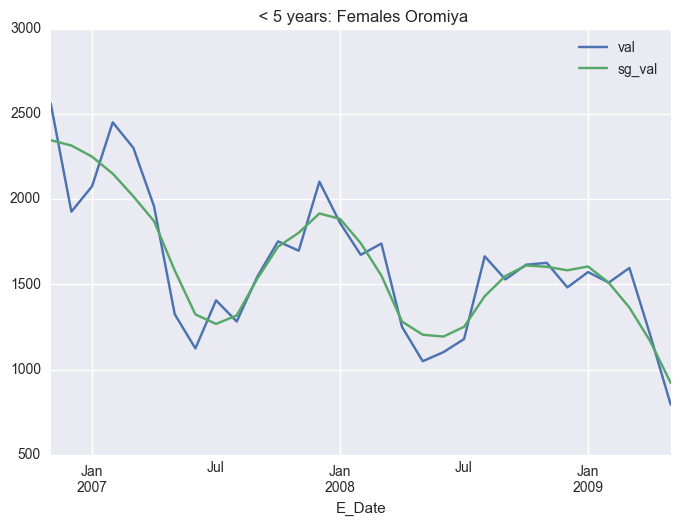

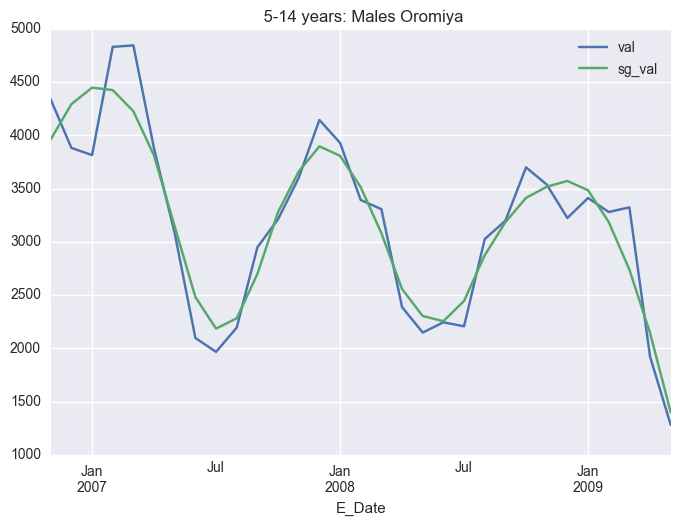

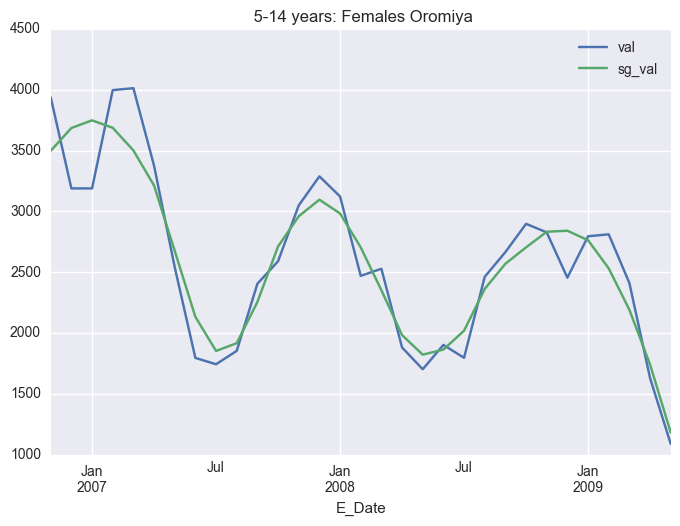

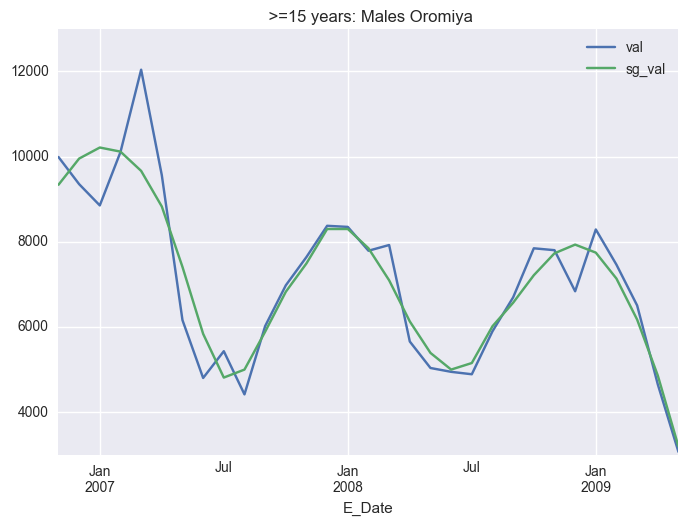

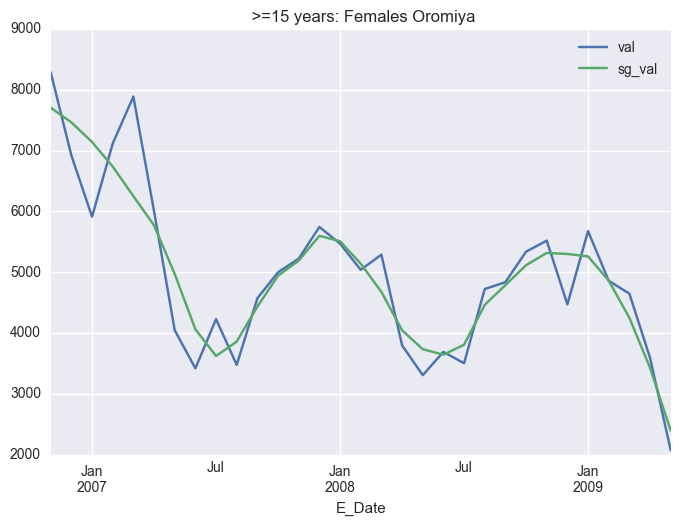

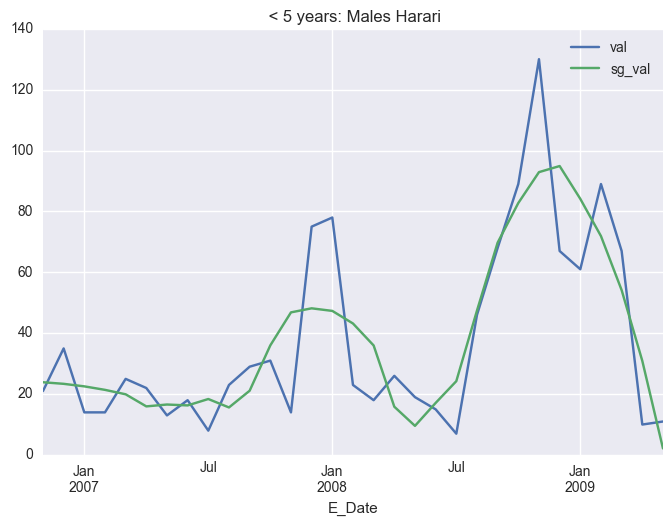

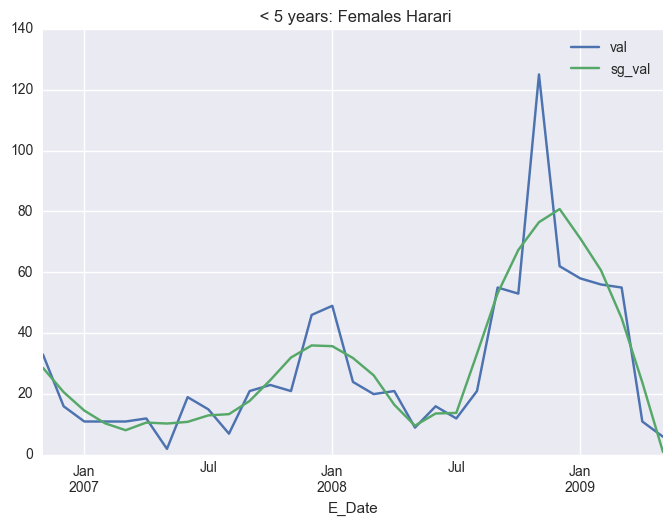

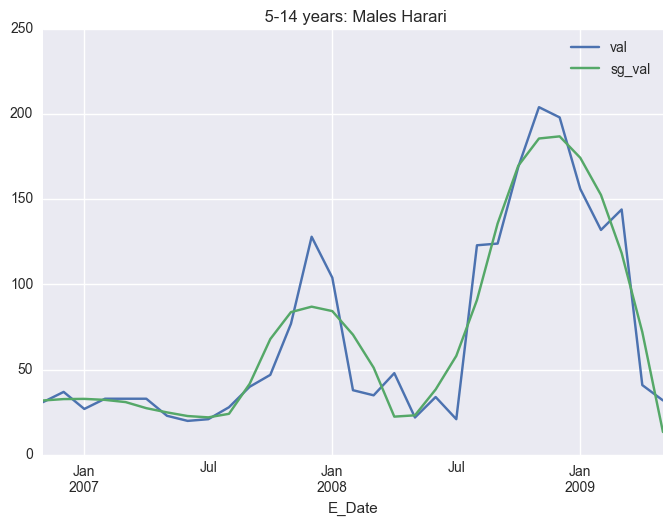

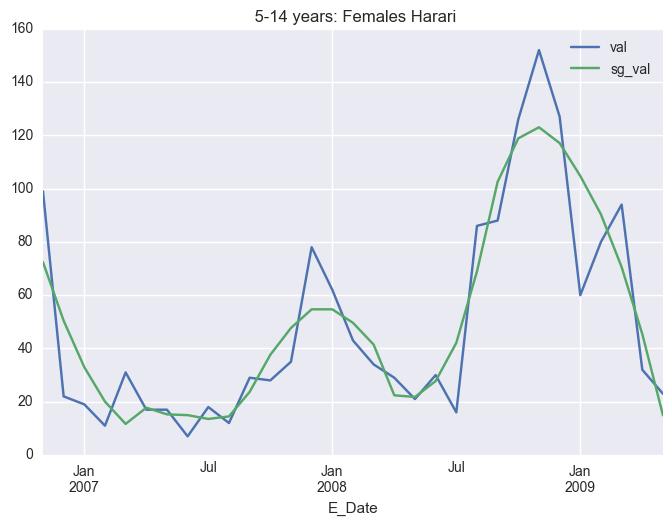

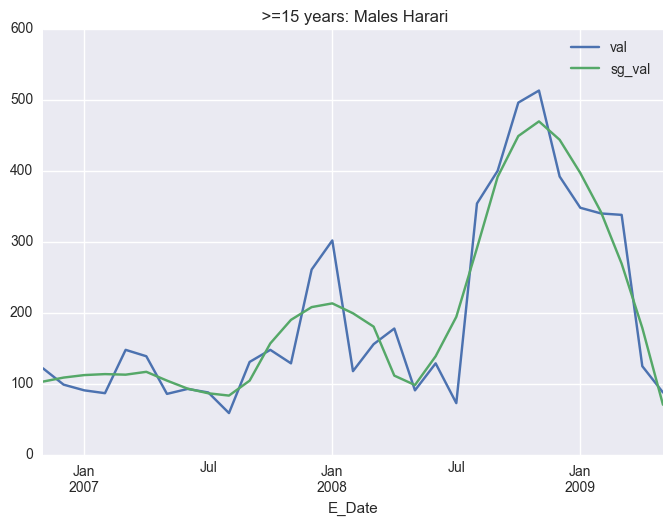

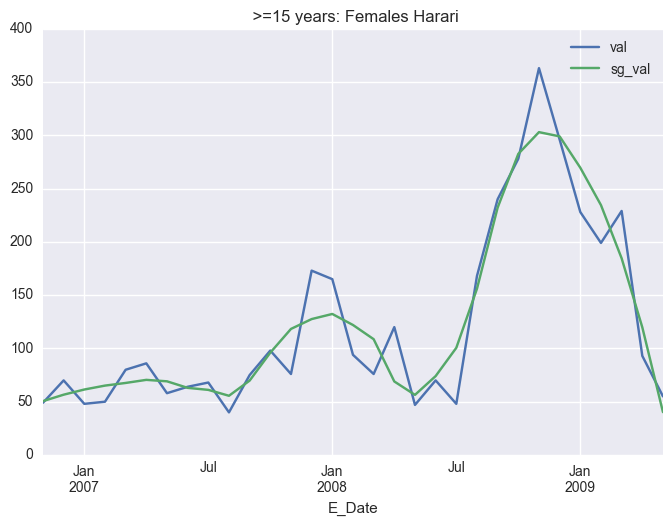

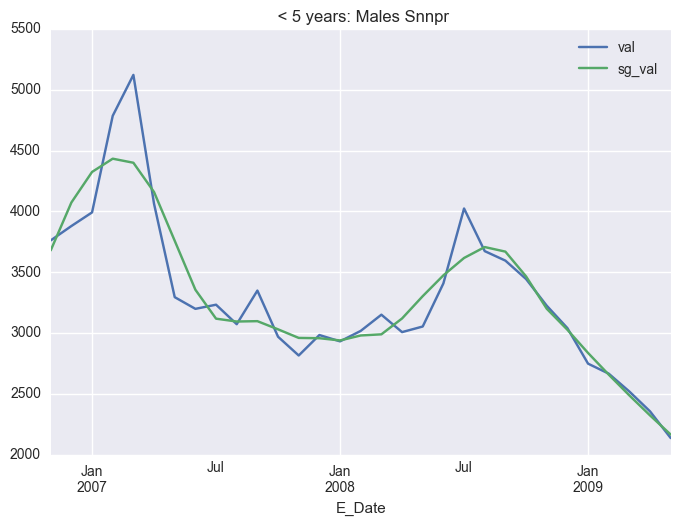

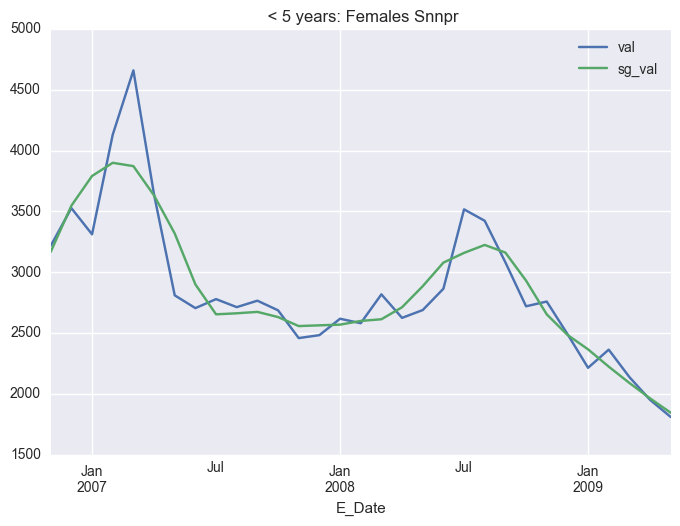

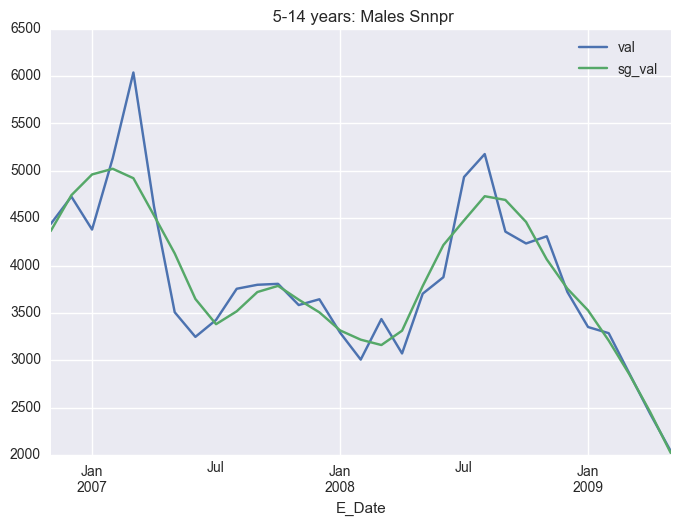

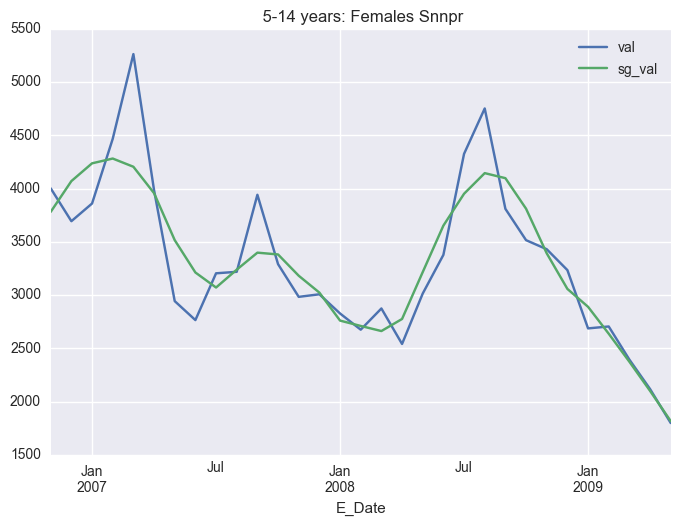

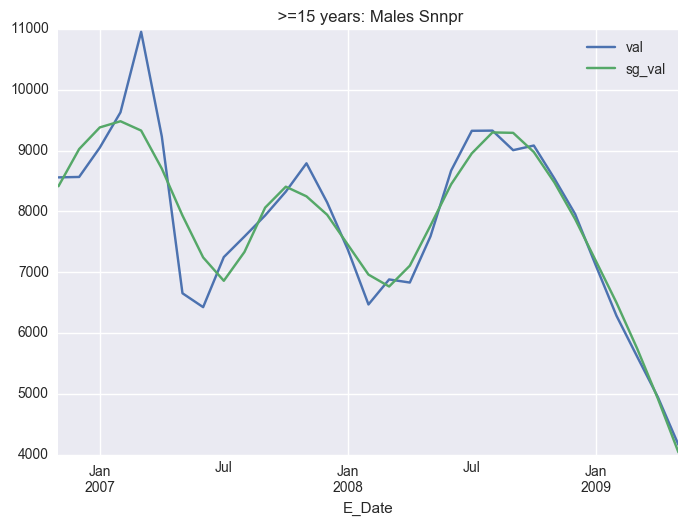

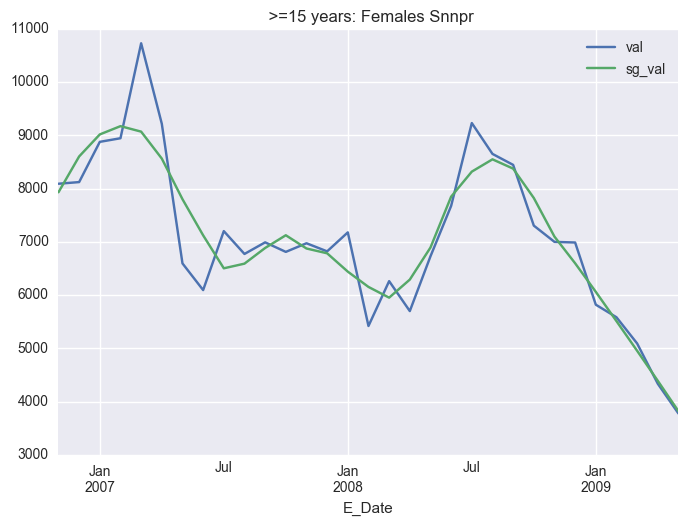

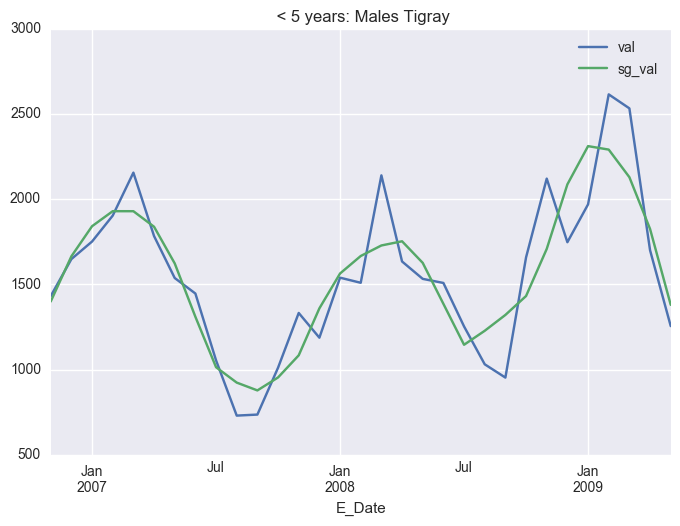

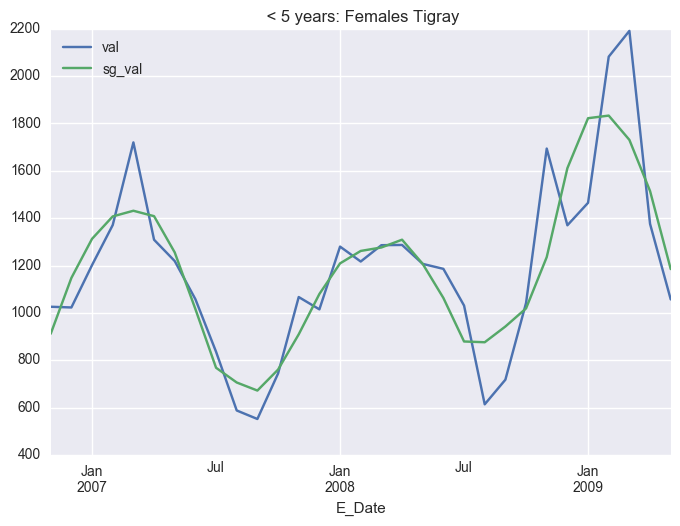

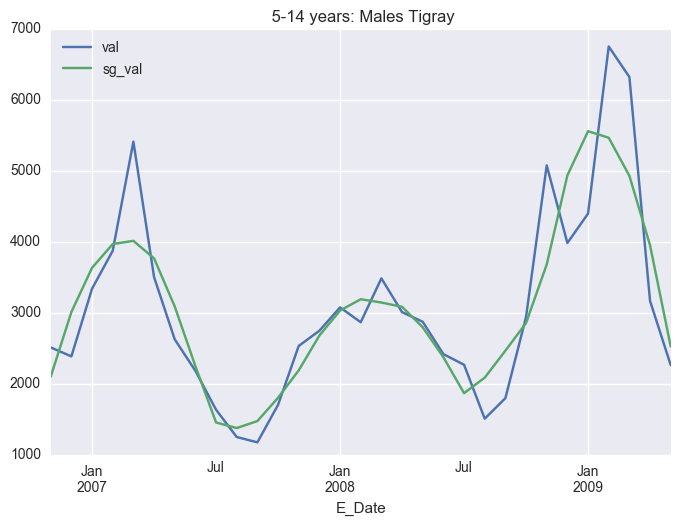

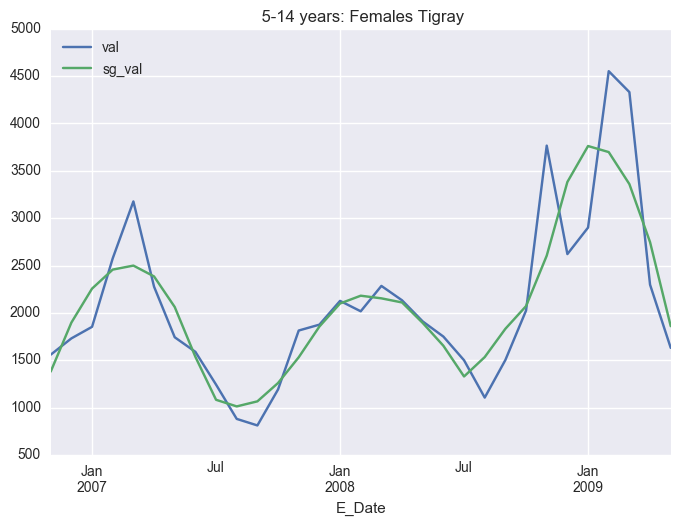

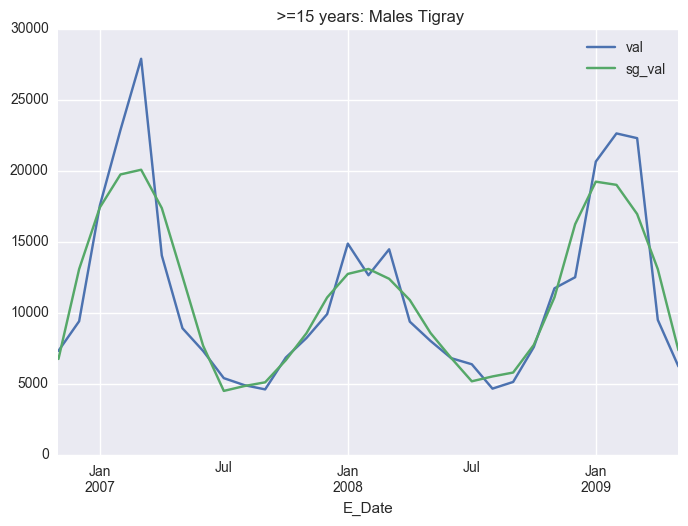

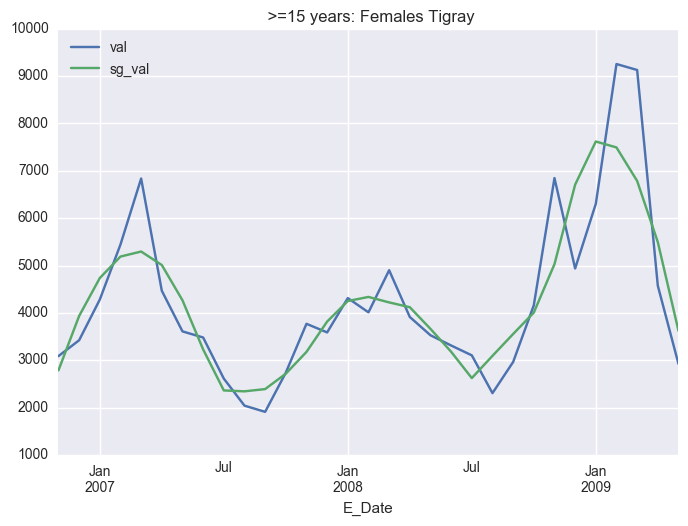

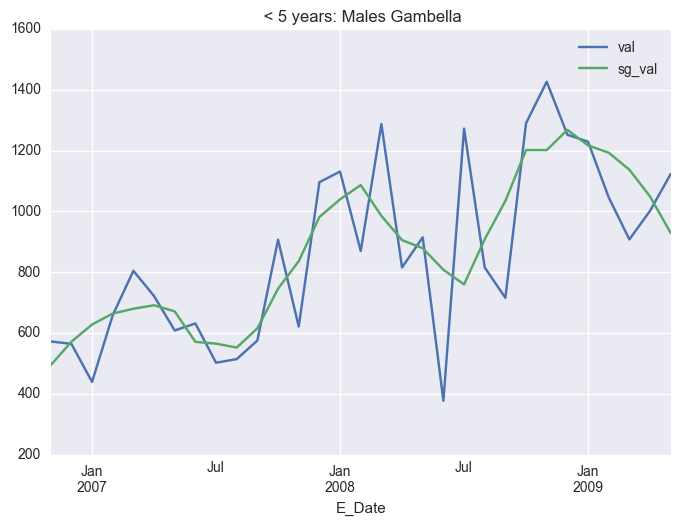

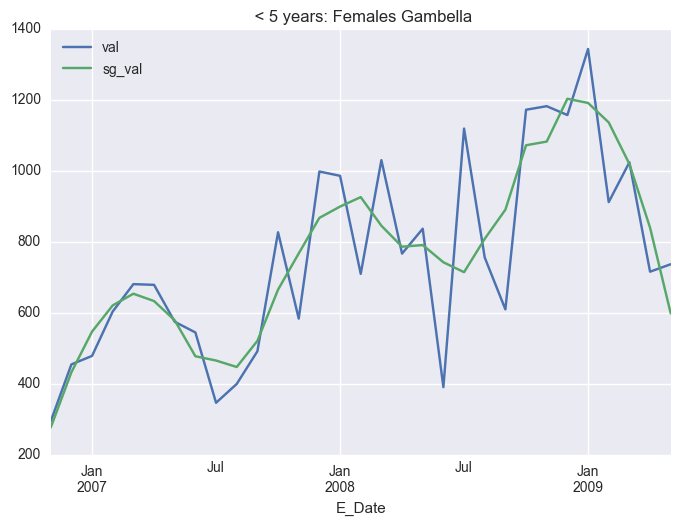

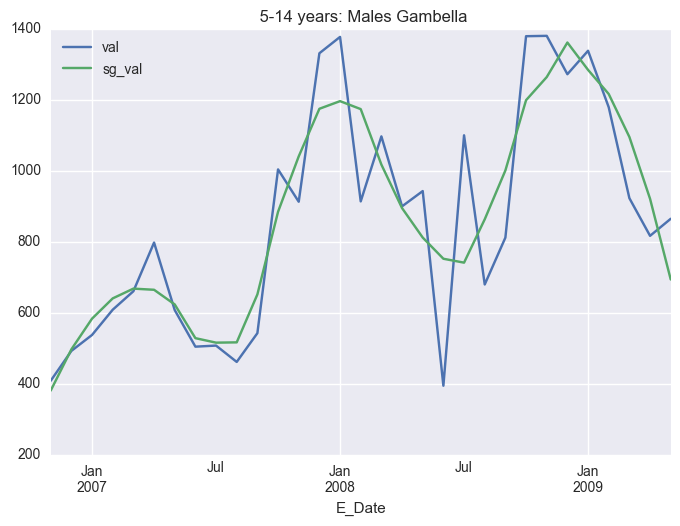

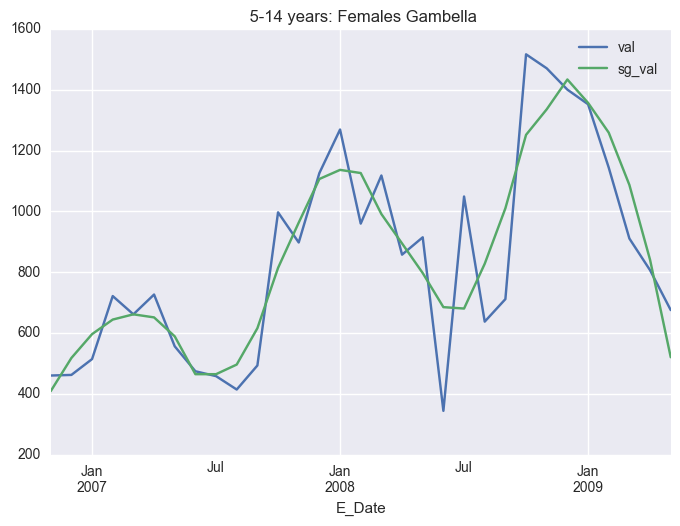

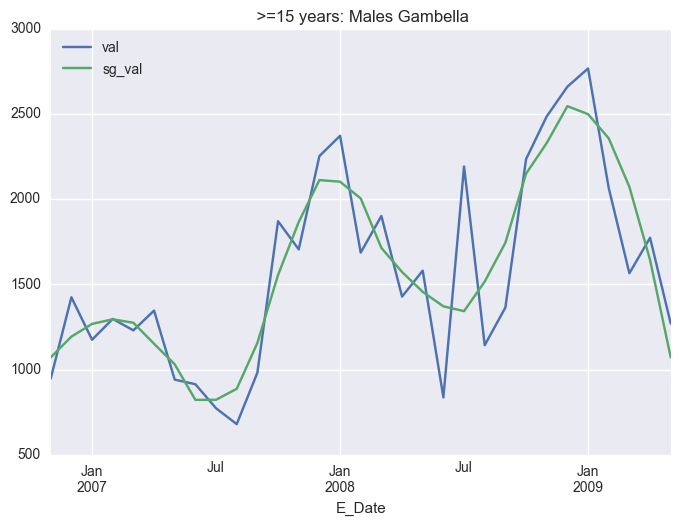

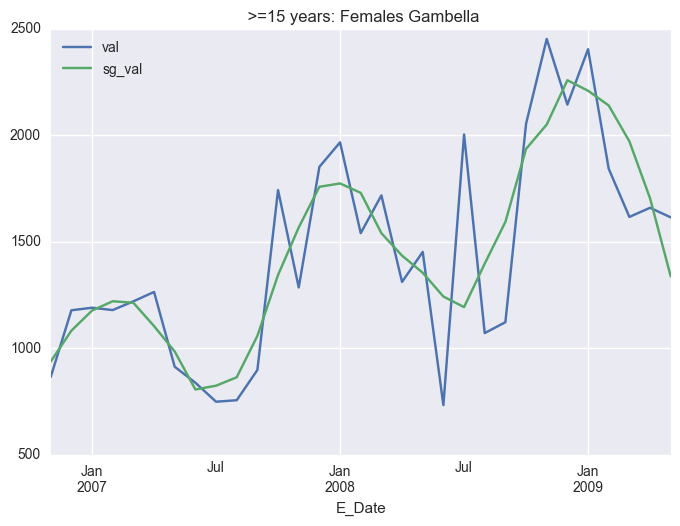

In [28]:
# Plot
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
for region in regions:
    for indicator in malaria_indicators:
        ind_data = DF_ind_malaria[(DF_ind_malaria['Region'] == region) & (DF_ind_malaria['Indicator'] == indicator)]
        ind_data.set_index('E_Date')[['val', 'sg_val']].plot()
        plt.title('%s %s' % (indicator.split('malaria')[-1], region.title()))
        plt.savefig('%s/spline_%s_%s.png' % (savedir, region, indicator))

<h1> Add log10 of value </h1>

In [27]:
DF_ind_malaria['log_val'] = [np.log10(val+1) for val in DF_ind_malaria['val']]
DF_ind_malaria['log_sg_val'] = [np.log10(sg_val+1) for sg_val in DF_ind_malaria['sg_val']]

<h1> Save dataframe to csv - only indicators with malaria counts </h1>

In [28]:
DF_ind_malaria.to_csv('Malaria_regional_3-24-2017.csv')

<h1> Exploratory figures </h1>

<h1> Plot correlation matrix </h1>

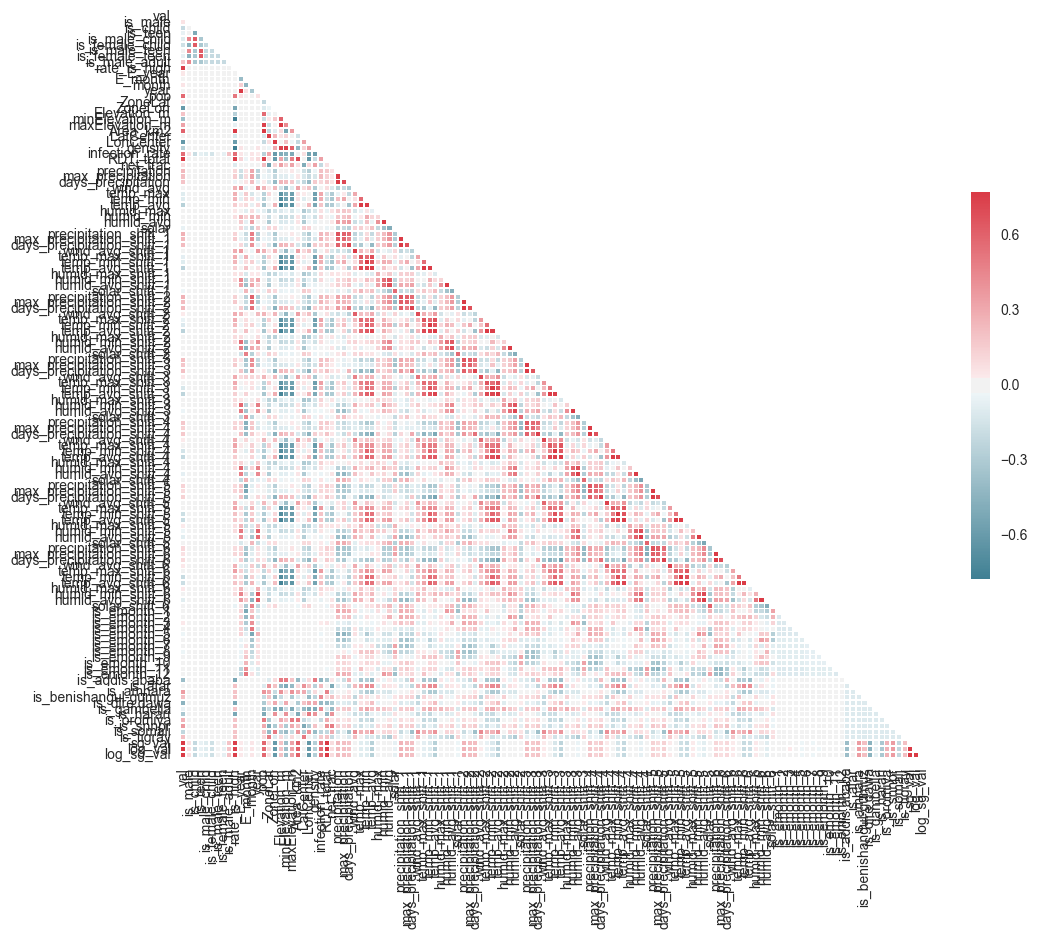

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_plot(corr):
    sns.set(style="white")
    # Generate a mask for the upper triangle,
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figur
    f, ax = plt.subplots(figsize=(12, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

    
#for region in DF_ind['Region'].unique():
    # Only select indicators relavent to malaria (no composite indicators)
corr_plot(DF_ind_malaria.corr(method='spearman'))

<h1> View correlations to the malaria value </h1>

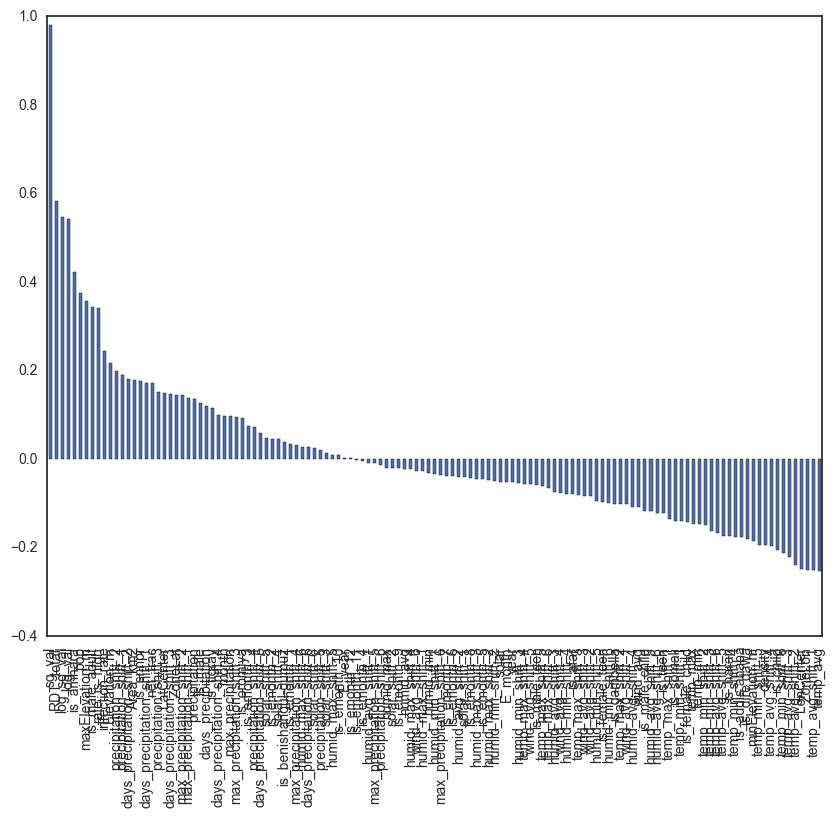

In [30]:
DF_ind_malaria.corr().val[1:].sort_values(ascending=False).plot.bar(figsize=(10,8))

<h1> view elevation distribution by age/gender </h1>

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


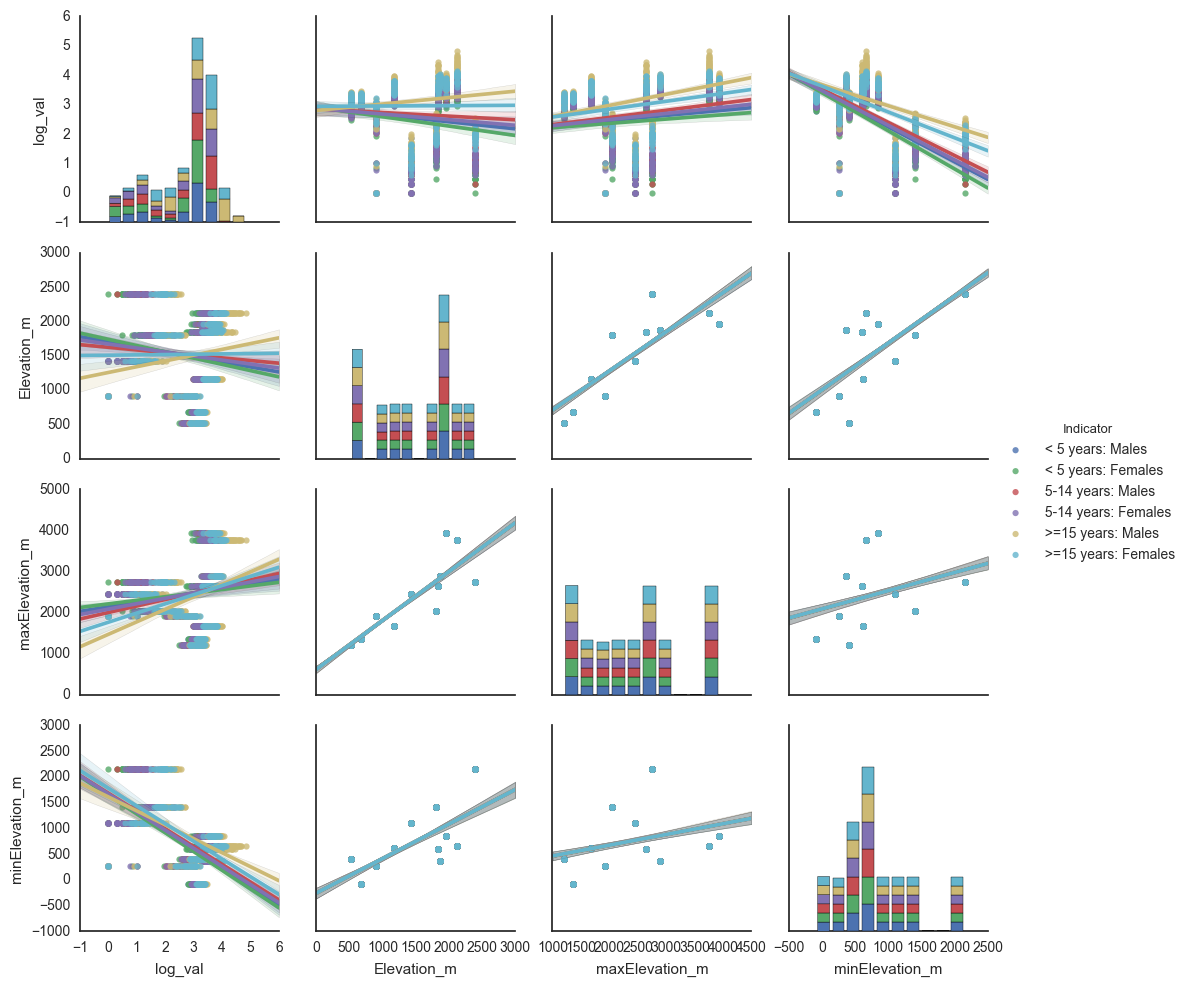

In [25]:
elevation_cols = ['log_val', 'Elevation_m', 'maxElevation_m', 'minElevation_m', 'Region', 'Indicator']
elv_data = DF_ind_malaria[elevation_cols]
elv_data['Indicator'] = [name.split('malaria')[-1] for name in elv_data['Indicator']]

g = sns.pairplot(elv_data, hue='Indicator', kind='reg')

<h1> plot only one row </h1>

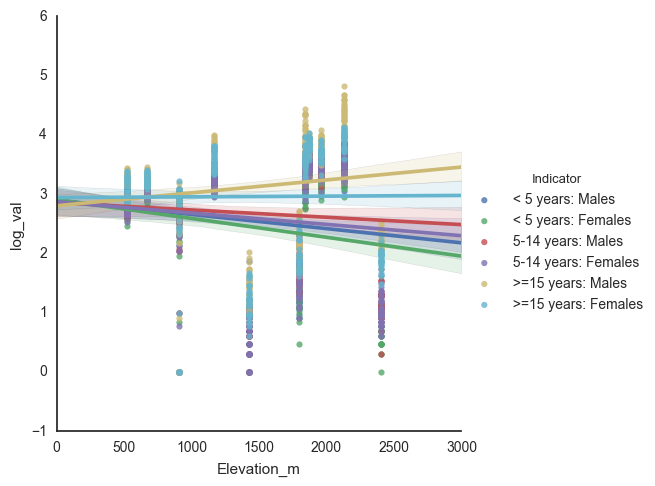

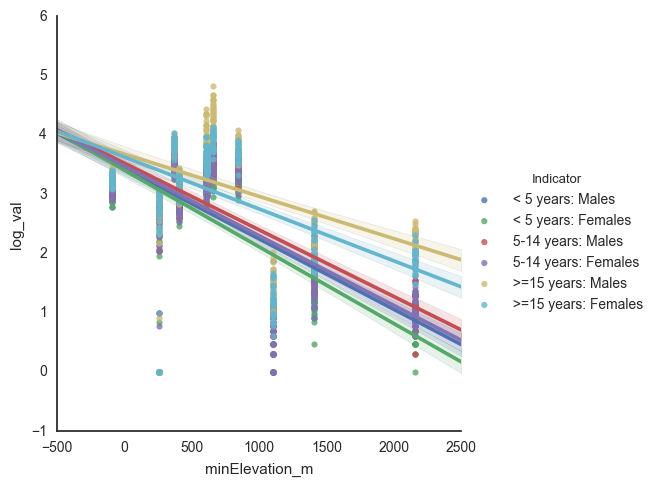

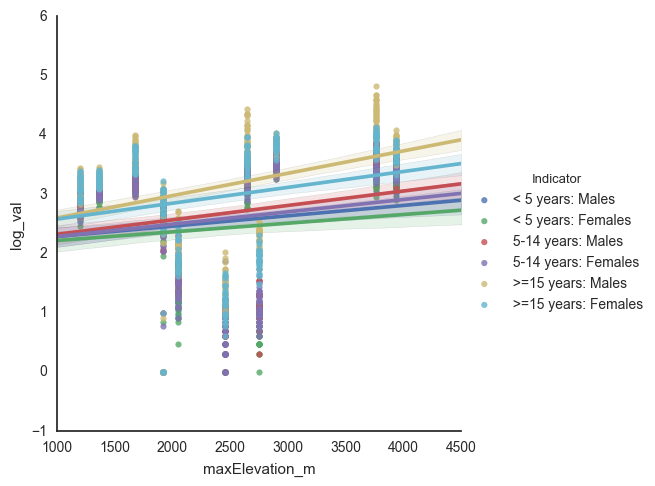

In [206]:
#fig, axs = plt.subplots(ncols=3)
sns.lmplot(x='Elevation_m', y='log_val', hue='Indicator', data=elv_data)
sns.lmplot(x='minElevation_m', y='log_val', hue='Indicator', data=elv_data)
sns.lmplot(x='maxElevation_m', y='log_val', hue='Indicator', data=elv_data)

<h1> view by region </h1>

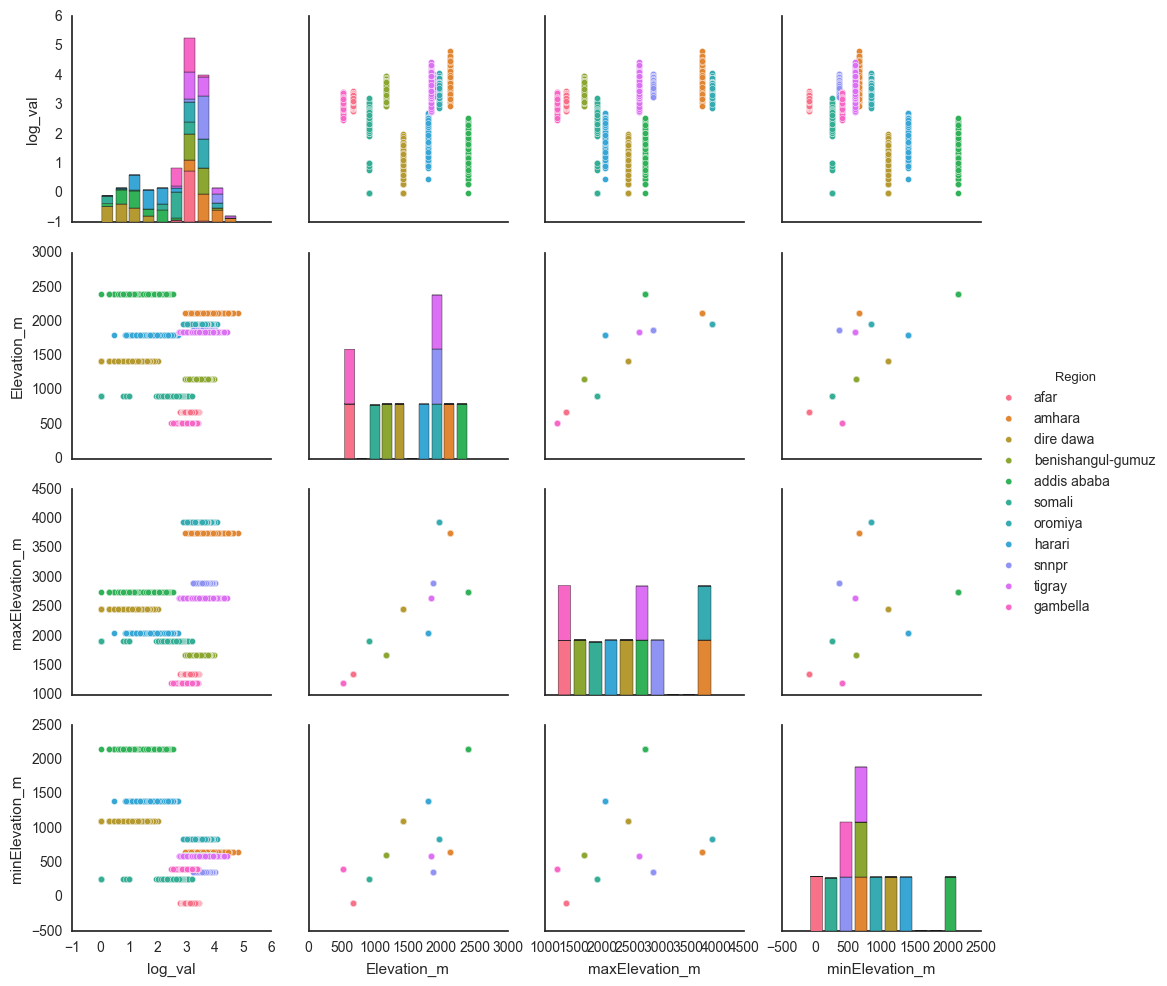

In [123]:
elevation_cols = ['log_val', 'Elevation_m', 'maxElevation_m', 'minElevation_m', 'Region', 'Indicator']
elv_data = DF_ind_malaria[elevation_cols]

g = sns.pairplot(elv_data, hue='Region', kind='scatter')

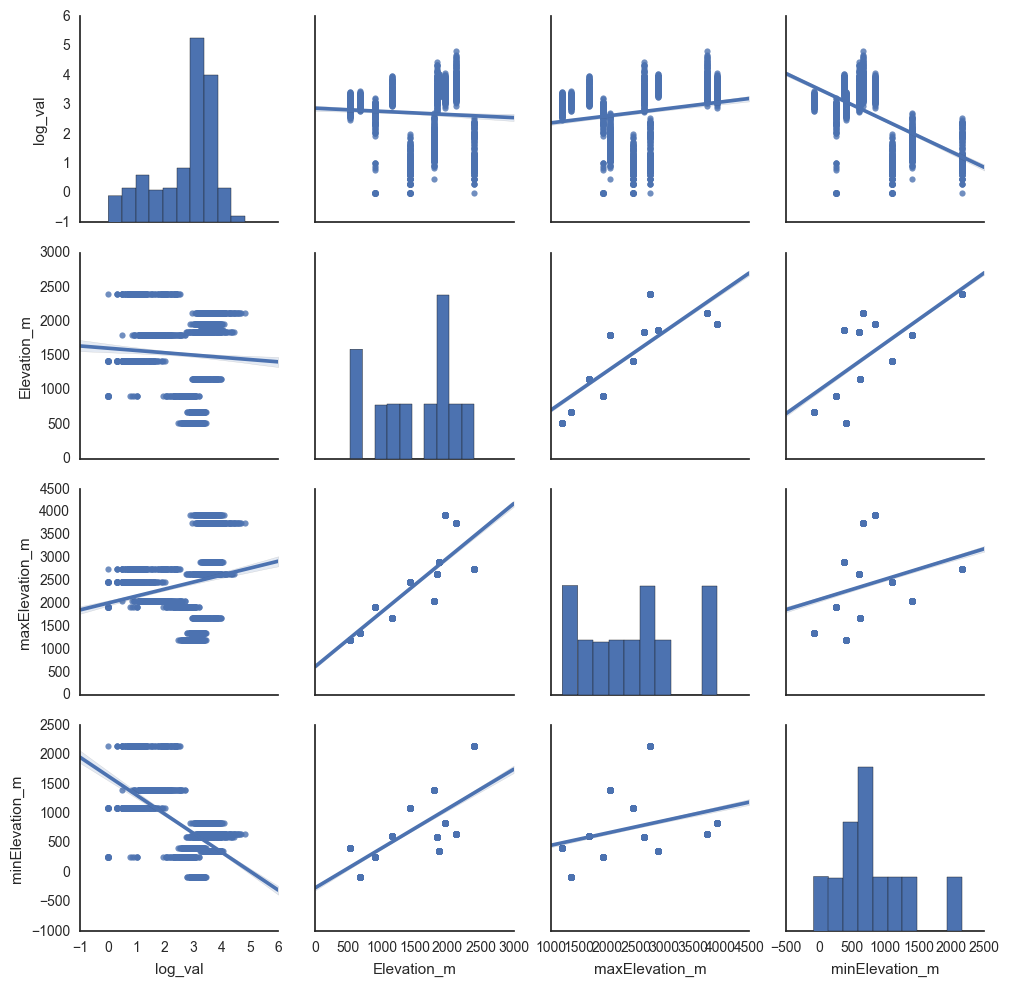

In [207]:
g = sns.pairplot(elv_data, kind="reg")

<h1> View correlation with weather </h1>

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


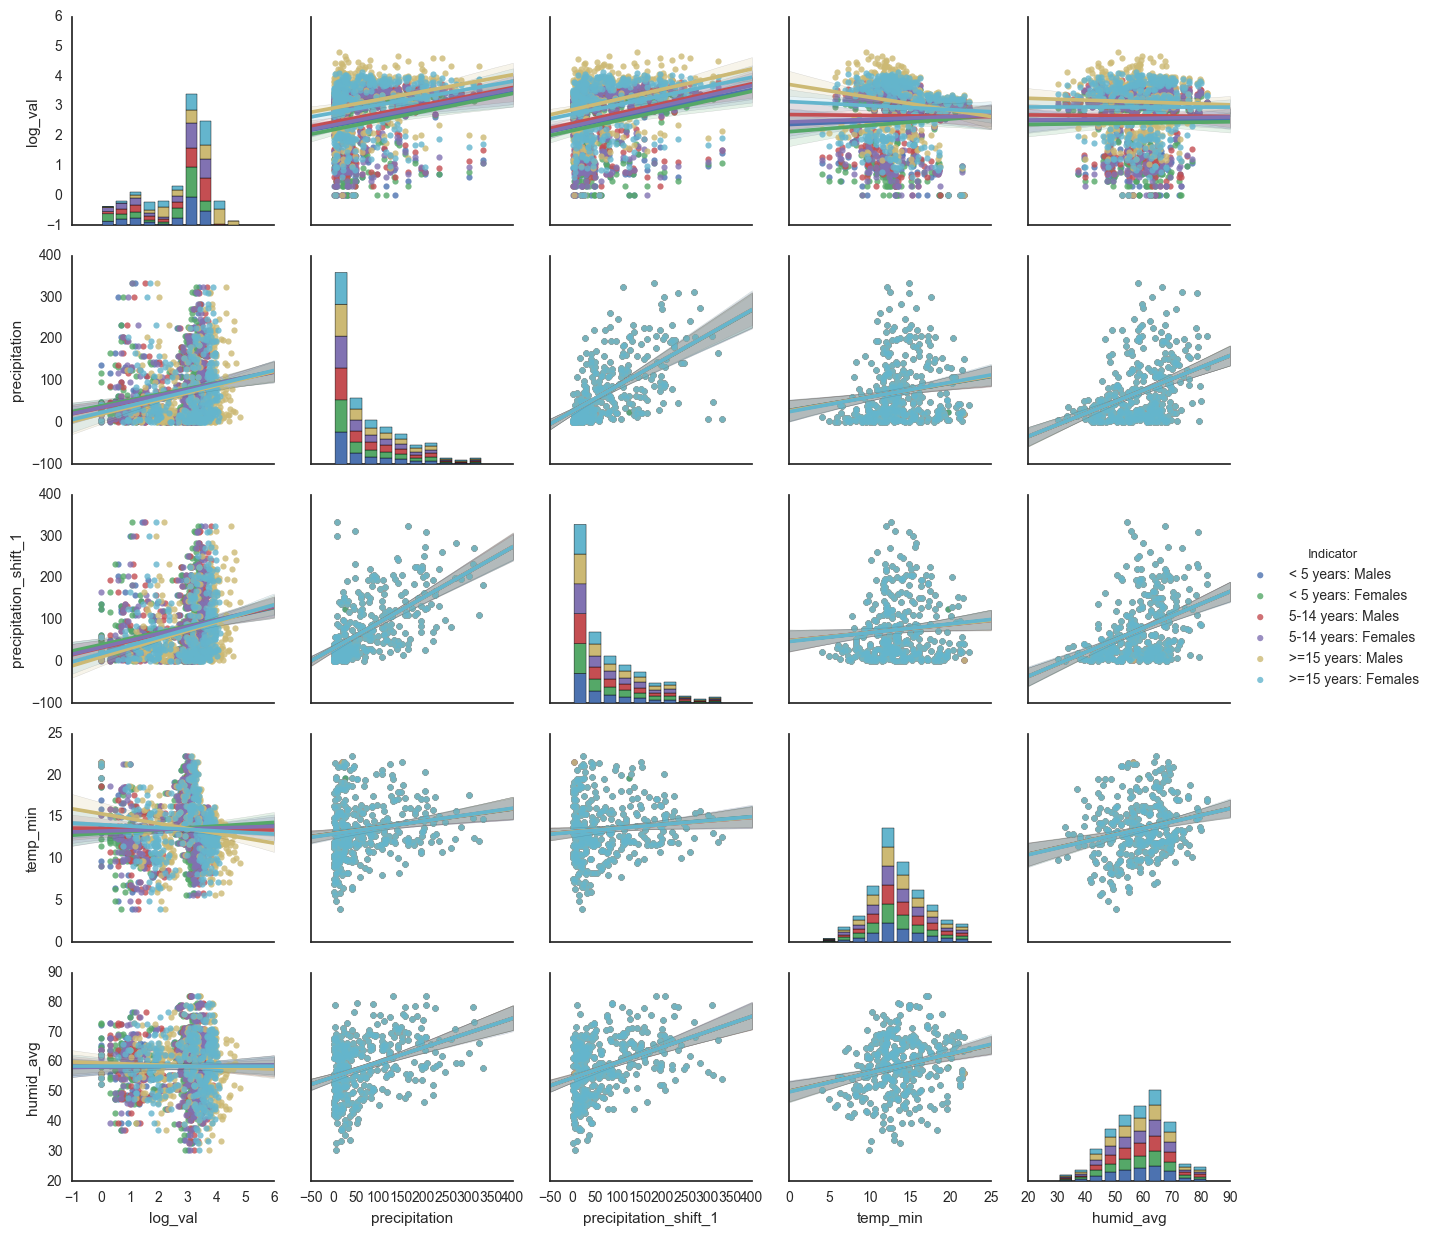

In [34]:
weather_cols = ['log_val', 'precipitation', 'precipitation_shift_1', 'temp_min', 'humid_avg', 'Region', 'Indicator']
weather_cut = DF_ind_malaria[weather_cols]
weather_cut['Indicator'] = [name.split('malaria')[-1] for name in weather_cut['Indicator']]

g = sns.pairplot(weather_cut, hue='Indicator', kind='reg')

<h1> weather correlations </h1>

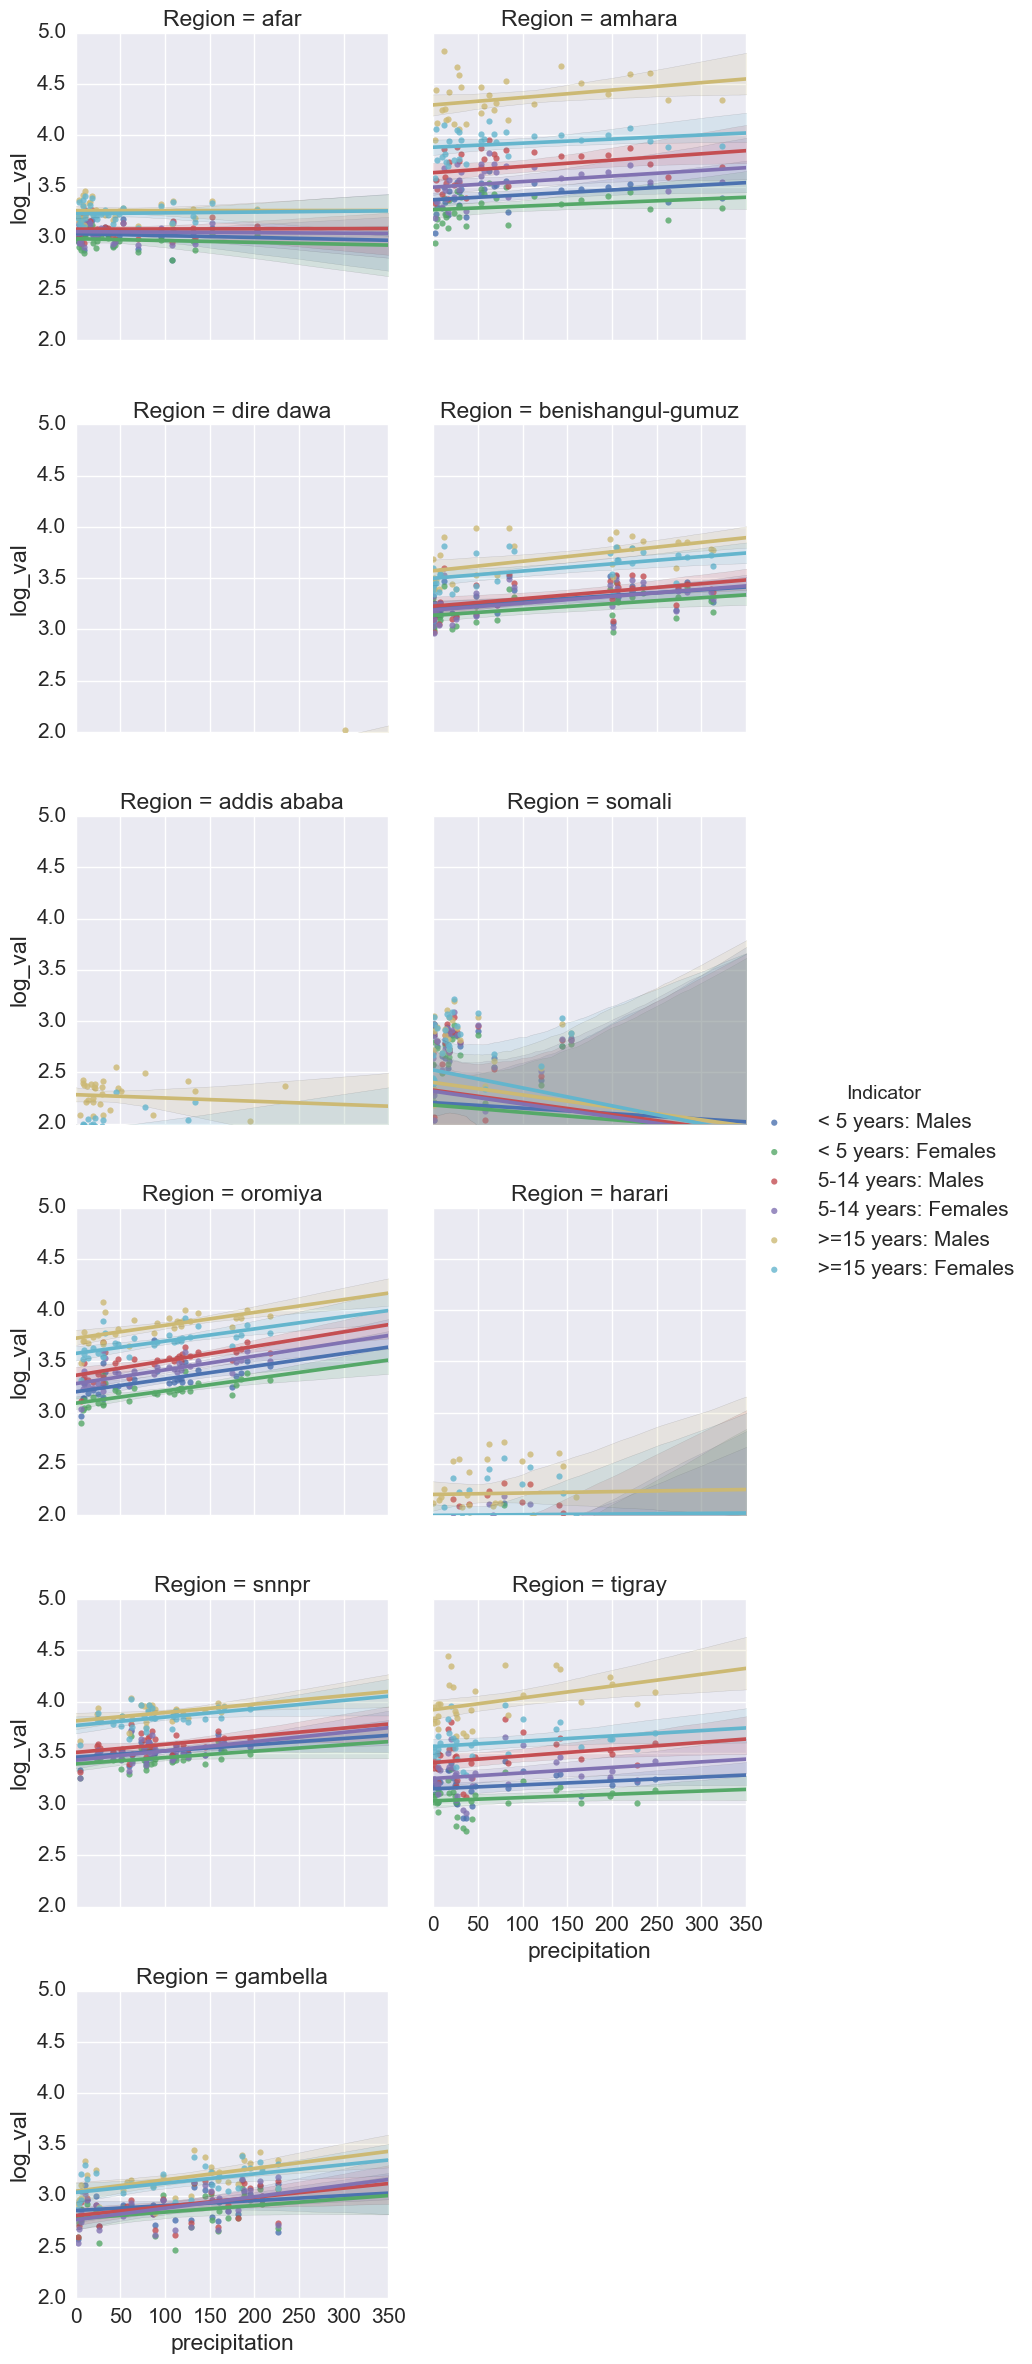

In [56]:
sns.set(font_scale=1.5)
sns.lmplot(x='precipitation', y='log_val',  col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=4)\
.set(ylim=(0, 5), xlim=(0, 350))

#sns.lmplot(x='humid_avg', y='log_val', col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))
#sns.lmplot(x='temp_min', y='log_val', col='Region', hue='Indicator', data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> decompose correlations with precipitations  for all regions for each indicator</h1>

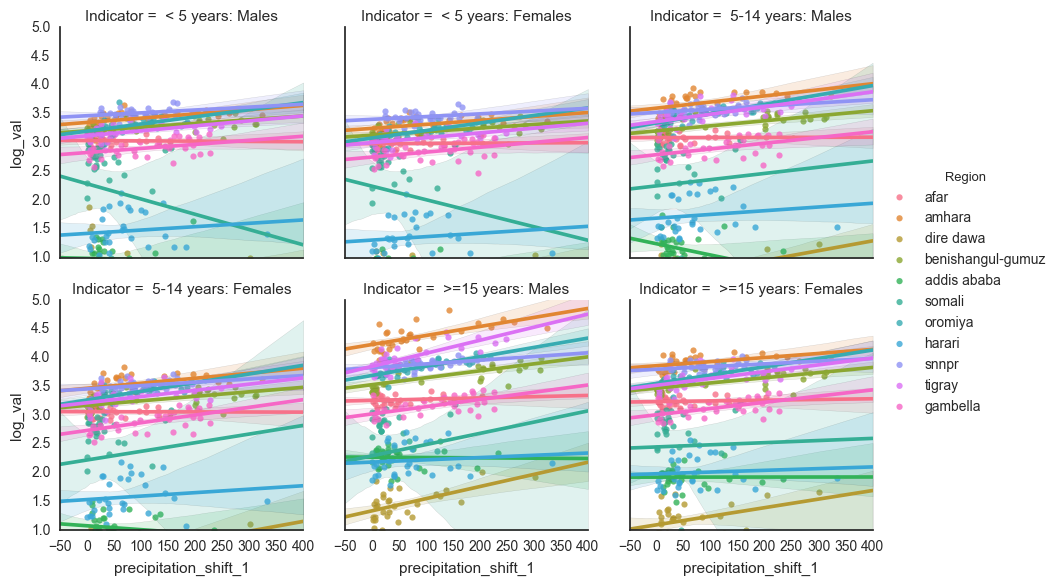

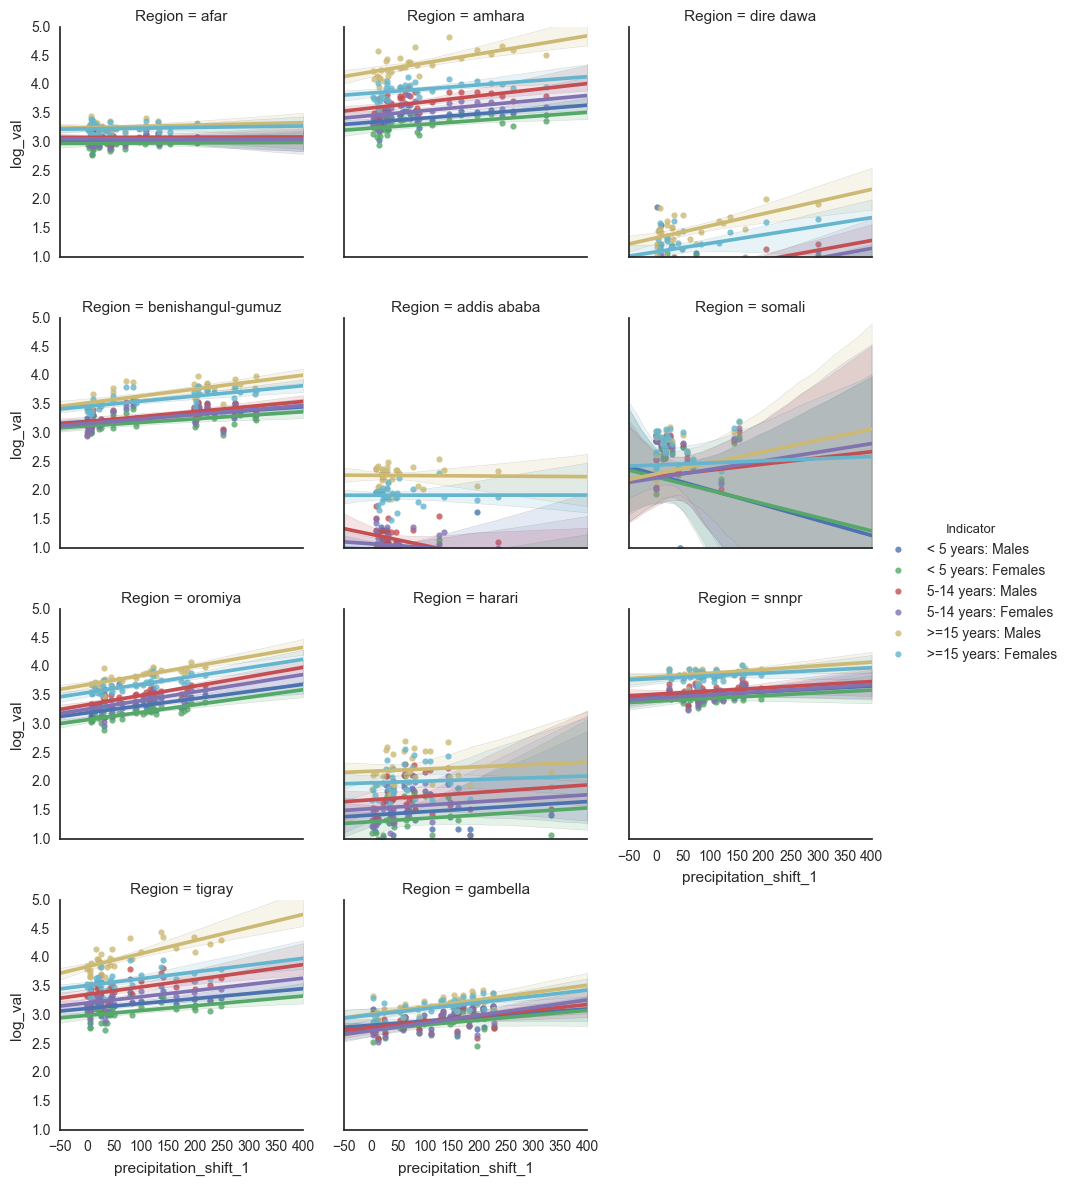

In [30]:
g = sns.lmplot(x='precipitation_shift_1', y='log_val', col='Indicator', hue='Region', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

g = sns.lmplot(x='precipitation_shift_1', y='log_val', col='Region', hue='Indicator', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> Impact of temperature for each region</h1>

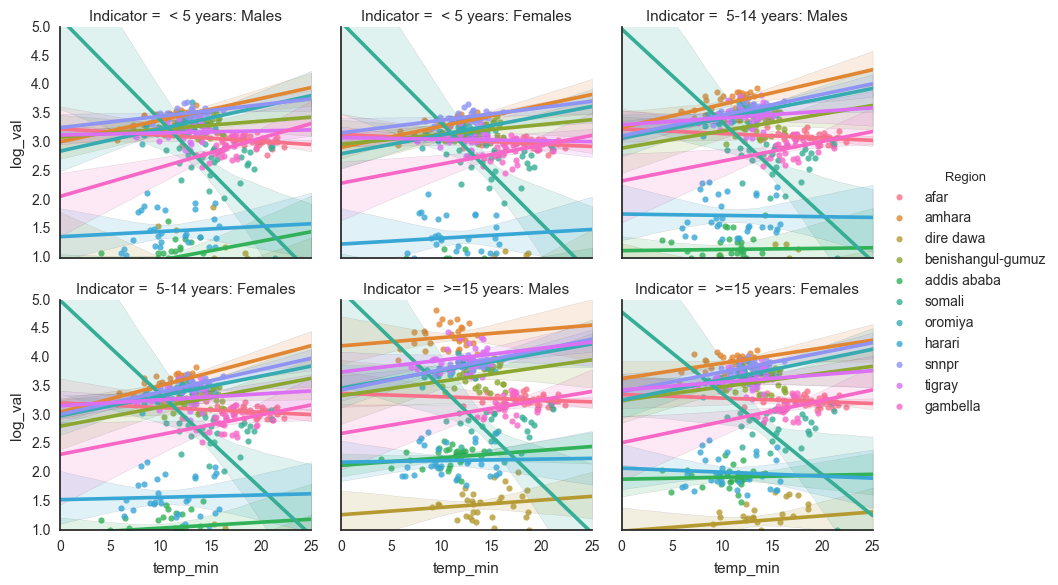

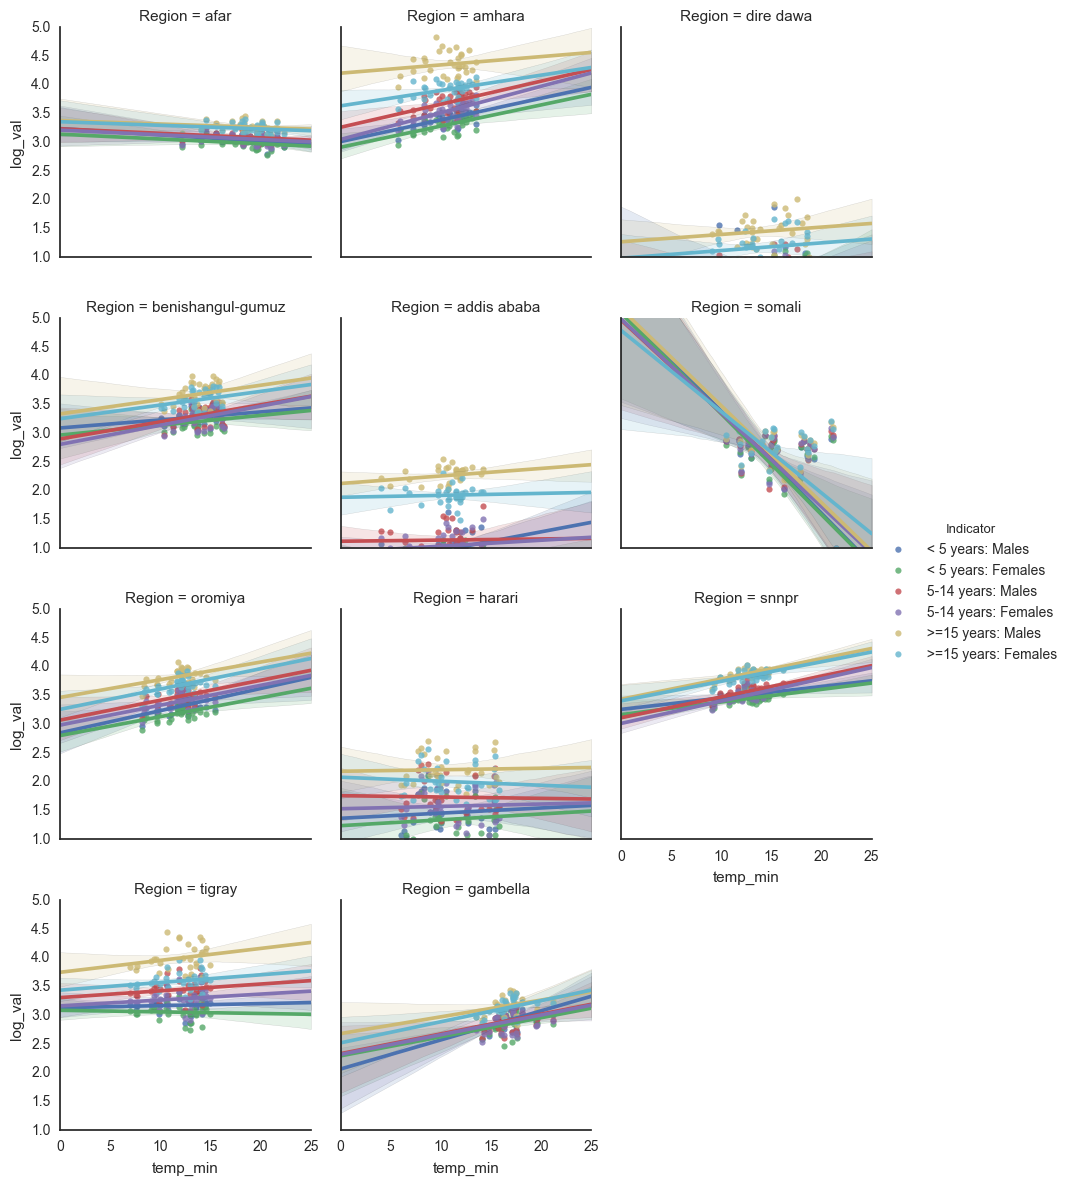

In [35]:
g = sns.lmplot(x='temp_min', y='log_val', col='Indicator', hue='Region', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

g = sns.lmplot(x='temp_min', y='log_val', col='Region', hue='Indicator', \
               data=weather_cut, col_wrap=3, size=3).set(ylim=(1, 5))

<h1> view precipitation and temperature </h1>

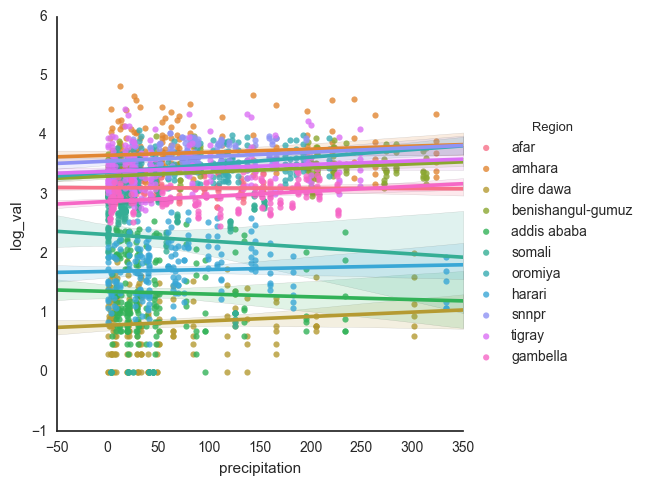

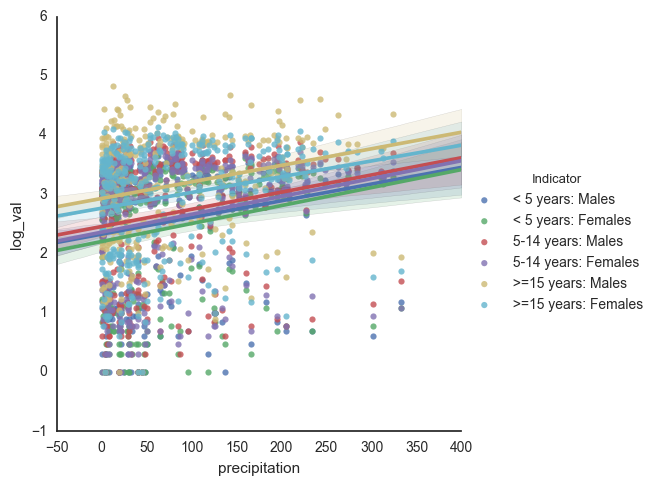

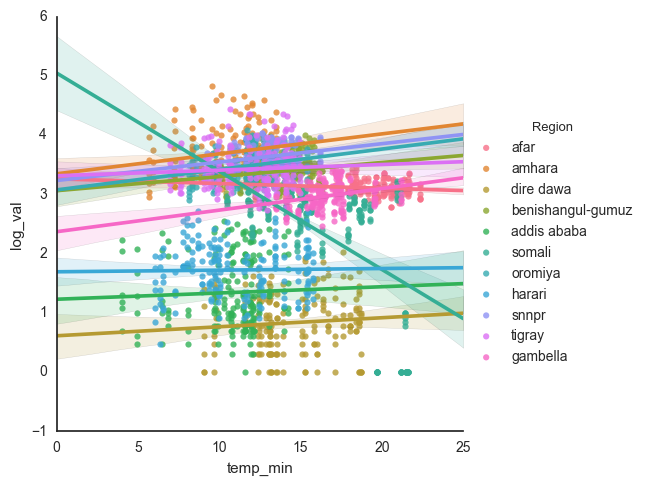

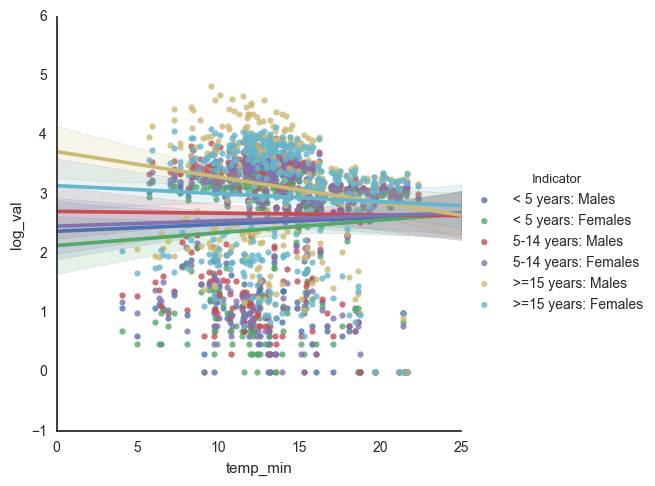

In [36]:
sns.lmplot(x='precipitation', y='log_val', hue='Region', data=weather_cut)
sns.lmplot(x='precipitation', y='log_val', hue='Indicator', data=weather_cut)

sns.lmplot(x='temp_min', y='log_val', hue='Region', data=weather_cut)
sns.lmplot(x='temp_min', y='log_val', hue='Indicator', data=weather_cut)
